In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

df = pd.read_csv('new_data_task1\merged_order_df1.csv')
df['date'] = pd.to_datetime(df['order_purchase_timestamp'])
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df['dayofyear'] = df.date.dt.dayofyear
df['dayofweek'] = df.date.dt.dayofweek
df['date_day'] = pd.to_datetime(df[['year', 'month', 'day']])

# Встановлення індексу 
df.set_index('date_day', inplace=True)
df.sort_index(inplace=True)

grouped = df.groupby(['product_category_name_english', pd.Grouper(freq='D')])['price'].sum().reset_index()

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # Визначення кількості змінних у вхідних даних
    n_vars = 1 if type(data) is list else data.shape[1]

    df = pd.DataFrame(data)
    # Список для зберігання зсувів (лагів) даних та їх назв
    cols, names = list(), list()
    # Вхідна послідовність (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        # Додавання зсуву (лагу) для кожної змінної
        cols.append(df.shift(i))
        # Формування назв зсувів (лагів) для кожної змінної
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Прогнозована послідовність (t, t+1, ... t+n)
    for i in range(0, n_out):
        # Додавання зсуву (лагу) для кожної змінної
        cols.append(df.shift(-i))
        # Формування назв прогнозованих значень для кожної змінної
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Об'єднання всіх зсувів (лагів) та прогнозованих значень в один DataFrame
    agg = pd.concat(cols, axis=1)
    agg.columns = names  # Назви стовпців
    # Видалення рядків з NaN значеннями
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# Функція для прогнозування
def forecast_demand_nn(grouped_df):
    forecasts = {}  
    all_categories_dfs = [] 
    categories = grouped_df['product_category_name_english'].unique()  

    for category in categories[:]:  
        category_df = grouped_df[grouped_df['product_category_name_english'] == category]  

        # Відновлення відсутніх дат та значень ціни
        category_df.index = category_df['date_day']  
        category_df = category_df.resample('D').asfreq()  
        category_df['date_day'] = pd.to_datetime(category_df.index)  
        category_df['year'] = category_df.date_day.dt.year  
        category_df['month'] = category_df.date_day.dt.month 
        category_df['day'] = category_df.date_day.dt.day 
        category_df['dayofyear'] = category_df.date_day.dt.dayofyear 
        category_df['dayofweek'] = category_df.date_day.dt.dayofweek

        category_df['product_category_name_english'] = category 

        category_df['price'] = category_df['price'].fillna(0)

        # Масштабування даних
        scaler = MinMaxScaler(feature_range=(0, 1))  
        scaled_data = scaler.fit_transform(category_df['price'].values.reshape(-1, 1))

        # Підготовка даних 
        n_lag = 7  
        n_ahead = 21  
        reframed = series_to_supervised(scaled_data, n_lag, n_ahead)  
        values = reframed.values  
        n_train_days = int(len(values) * 0.8) 
        train = values[:n_train_days, :]  
        test = values[n_train_days:, :] 
        train_X, train_y = train[:, :n_lag], train[:, -n_ahead:] 
        test_X, test_y = test[:, :n_lag], test[:, -n_ahead:] 
        train_X = train_X.reshape((train_X.shape[0], n_lag)) 
        test_X = test_X.reshape((test_X.shape[0], n_lag))  

        model = Sequential()
        model.add(Dense(50, input_dim=n_lag, activation='relu'))
        model.add(Dense(n_ahead))
        model.compile(optimizer='adam', loss='mse')
        model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=2)

        forecast = model.predict(test_X[-1].reshape(1, -1))

        forecast = scaler.inverse_transform(forecast)

        forecasts[category] = forecast.flatten()  
        all_categories_dfs.append(category_df)  

    return forecasts, all_categories_dfs  

demand_forecast_nn, all_categories_dfs_nn = forecast_demand_nn(grouped)

Epoch 1/50


c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 33ms/step - loss: 0.0123
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0113
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0110
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0109
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0108
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0107
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0106
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0106
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0105
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0105
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0104
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0104
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0104
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0104
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0104
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0103
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0103
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0103
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0103
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0103
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0115
Epoch 2/50
17/17 - 0s - 1ms/step - loss: 0.0103
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0100
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0098
Epoch 5/50
17/17 - 0s - 1ms/step - loss: 0.0097
Epoch 6/50
17/17 - 0s - 1ms/step - loss: 0.0096
Epoch 7/50
17/17 - 0s - 1ms/step - loss: 0.0096
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0095
Epoch 9/50
17/17 - 0s - 1ms/step - loss: 0.0095
Epoch 10/50
17/17 - 0s - 1ms/step - loss: 0.0095
Epoch 11/50
17/17 - 0s - 1ms/step - loss: 0.0094
Epoch 12/50
17/17 - 0s - 1ms/step - loss: 0.0094
Epoch 13/50
17/17 - 0s - 1ms/step - loss: 0.0094
Epoch 14/50
17/17 - 0s - 1ms/step - loss: 0.0094
Epoch 15/50
17/17 - 0s - 1ms/step - loss: 0.0093
Epoch 16/50
17/17 - 0s - 1ms/step - loss: 0.0093
Epoch 17/50
17/17 - 0s - 2ms/step - loss: 0.0093
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0093
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0093
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0093
Epoch 21/50
17/17 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 - 1s - 46ms/step - loss: 0.0028
Epoch 2/50
13/13 - 0s - 2ms/step - loss: 0.0027
Epoch 3/50
13/13 - 0s - 2ms/step - loss: 0.0027
Epoch 4/50
13/13 - 0s - 2ms/step - loss: 0.0026
Epoch 5/50
13/13 - 0s - 2ms/step - loss: 0.0026
Epoch 6/50
13/13 - 0s - 2ms/step - loss: 0.0026
Epoch 7/50
13/13 - 0s - 2ms/step - loss: 0.0026
Epoch 8/50
13/13 - 0s - 2ms/step - loss: 0.0025
Epoch 9/50
13/13 - 0s - 2ms/step - loss: 0.0025
Epoch 10/50
13/13 - 0s - 2ms/step - loss: 0.0025
Epoch 11/50
13/13 - 0s - 2ms/step - loss: 0.0025
Epoch 12/50
13/13 - 0s - 2ms/step - loss: 0.0025
Epoch 13/50
13/13 - 0s - 2ms/step - loss: 0.0025
Epoch 14/50
13/13 - 0s - 4ms/step - loss: 0.0025
Epoch 15/50
13/13 - 0s - 2ms/step - loss: 0.0025
Epoch 16/50
13/13 - 0s - 2ms/step - loss: 0.0025
Epoch 17/50
13/13 - 0s - 2ms/step - loss: 0.0025
Epoch 18/50
13/13 - 0s - 2ms/step - loss: 0.0025
Epoch 19/50
13/13 - 0s - 2ms/step - loss: 0.0025
Epoch 20/50
13/13 - 0s - 2ms/step - loss: 0.0025
Epoch 21/50
13/13 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 - 0s - 38ms/step - loss: 9.4080e-04
Epoch 2/50
12/12 - 0s - 2ms/step - loss: 9.1124e-04
Epoch 3/50
12/12 - 0s - 2ms/step - loss: 8.9210e-04
Epoch 4/50
12/12 - 0s - 2ms/step - loss: 8.7902e-04
Epoch 5/50
12/12 - 0s - 4ms/step - loss: 8.7184e-04
Epoch 6/50
12/12 - 0s - 2ms/step - loss: 8.6421e-04
Epoch 7/50
12/12 - 0s - 2ms/step - loss: 8.6144e-04
Epoch 8/50
12/12 - 0s - 2ms/step - loss: 8.5725e-04
Epoch 9/50
12/12 - 0s - 2ms/step - loss: 8.5462e-04
Epoch 10/50
12/12 - 0s - 2ms/step - loss: 8.5077e-04
Epoch 11/50
12/12 - 0s - 2ms/step - loss: 8.4826e-04
Epoch 12/50
12/12 - 0s - 2ms/step - loss: 8.4745e-04
Epoch 13/50
12/12 - 0s - 2ms/step - loss: 8.4529e-04
Epoch 14/50
12/12 - 0s - 2ms/step - loss: 8.4349e-04
Epoch 15/50
12/12 - 0s - 2ms/step - loss: 8.4175e-04
Epoch 16/50
12/12 - 0s - 2ms/step - loss: 8.4143e-04
Epoch 17/50
12/12 - 0s - 2ms/step - loss: 8.4075e-04
Epoch 18/50
12/12 - 0s - 2ms/step - loss: 8.3876e-04
Epoch 19/50
12/12 - 0s - 2ms/step - loss: 8.3928e-04
Epoch 20/50


c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 28ms/step - loss: 0.0084
Epoch 2/50
17/17 - 0s - 1ms/step - loss: 0.0072
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0069
Epoch 4/50
17/17 - 0s - 1ms/step - loss: 0.0067
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0066
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0065
Epoch 7/50
17/17 - 0s - 1ms/step - loss: 0.0064
Epoch 8/50
17/17 - 0s - 1ms/step - loss: 0.0063
Epoch 9/50
17/17 - 0s - 1ms/step - loss: 0.0062
Epoch 10/50
17/17 - 0s - 1ms/step - loss: 0.0062
Epoch 11/50
17/17 - 0s - 1ms/step - loss: 0.0061
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0061
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0060
Epoch 14/50
17/17 - 0s - 1ms/step - loss: 0.0060
Epoch 15/50
17/17 - 0s - 1ms/step - loss: 0.0059
Epoch 16/50
17/17 - 0s - 1ms/step - loss: 0.0059
Epoch 17/50
17/17 - 0s - 1ms/step - loss: 0.0059
Epoch 18/50
17/17 - 0s - 2ms/step - loss: 0.0059
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0058
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0058
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0218
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0147
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0121
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0115
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0113
Epoch 6/50
17/17 - 0s - 1ms/step - loss: 0.0111
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0109
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0108
Epoch 9/50
17/17 - 0s - 1ms/step - loss: 0.0107
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0106
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0106
Epoch 12/50
17/17 - 0s - 1ms/step - loss: 0.0105
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0104
Epoch 14/50
17/17 - 0s - 1ms/step - loss: 0.0104
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0103
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0103
Epoch 17/50
17/17 - 0s - 1ms/step - loss: 0.0102
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0102
Epoch 19/50
17/17 - 0s - 2ms/step - loss: 0.0101
Epoch 20/50
17/17 - 0s - 2ms/step - loss: 0.0100
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0177
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0137
Epoch 3/50
17/17 - 0s - 1ms/step - loss: 0.0129
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0125
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0123
Epoch 6/50
17/17 - 0s - 1ms/step - loss: 0.0121
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0120
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0119
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0118
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0117
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0116
Epoch 12/50
17/17 - 0s - 1ms/step - loss: 0.0116
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0115
Epoch 14/50
17/17 - 0s - 1ms/step - loss: 0.0115
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0114
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0114
Epoch 17/50
17/17 - 0s - 1ms/step - loss: 0.0113
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0113
Epoch 19/50
17/17 - 0s - 2ms/step - loss: 0.0113
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0112
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0087
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0052
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0042
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0039
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0037
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0036
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0035
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0035
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0034
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0033
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0033
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0033
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0032
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0032
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0031
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0031
Epoch 17/50
17/17 - 0s - 2ms/step - loss: 0.0031
Epoch 18/50
17/17 - 0s - 2ms/step - loss: 0.0031
Epoch 19/50
17/17 - 0s - 2ms/step - loss: 0.0030
Epoch 20/50
17/17 - 0s - 2ms/step - loss: 0.0030
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0058
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0051
Epoch 3/50
17/17 - 0s - 1ms/step - loss: 0.0050
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0049
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0049
Epoch 6/50
17/17 - 0s - 1ms/step - loss: 0.0049
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0048
Epoch 8/50
17/17 - 0s - 1ms/step - loss: 0.0048
Epoch 9/50
17/17 - 0s - 1ms/step - loss: 0.0048
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0048
Epoch 11/50
17/17 - 0s - 1ms/step - loss: 0.0048
Epoch 12/50
17/17 - 0s - 1ms/step - loss: 0.0048
Epoch 13/50
17/17 - 0s - 1ms/step - loss: 0.0047
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0047
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0047
Epoch 16/50
17/17 - 0s - 1ms/step - loss: 0.0047
Epoch 17/50
17/17 - 0s - 2ms/step - loss: 0.0047
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0047
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0047
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0047
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 - 0s - 35ms/step - loss: 0.0012
Epoch 2/50
13/13 - 0s - 2ms/step - loss: 0.0011
Epoch 3/50
13/13 - 0s - 2ms/step - loss: 0.0011
Epoch 4/50
13/13 - 0s - 2ms/step - loss: 0.0011
Epoch 5/50
13/13 - 0s - 2ms/step - loss: 0.0011
Epoch 6/50
13/13 - 0s - 2ms/step - loss: 0.0011
Epoch 7/50
13/13 - 0s - 2ms/step - loss: 0.0011
Epoch 8/50
13/13 - 0s - 2ms/step - loss: 0.0010
Epoch 9/50
13/13 - 0s - 2ms/step - loss: 0.0010
Epoch 10/50
13/13 - 0s - 2ms/step - loss: 0.0010
Epoch 11/50
13/13 - 0s - 2ms/step - loss: 0.0010
Epoch 12/50
13/13 - 0s - 2ms/step - loss: 0.0010
Epoch 13/50
13/13 - 0s - 2ms/step - loss: 0.0010
Epoch 14/50
13/13 - 0s - 2ms/step - loss: 0.0010
Epoch 15/50
13/13 - 0s - 2ms/step - loss: 0.0010
Epoch 16/50
13/13 - 0s - 4ms/step - loss: 0.0010
Epoch 17/50
13/13 - 0s - 2ms/step - loss: 0.0010
Epoch 18/50
13/13 - 0s - 2ms/step - loss: 0.0010
Epoch 19/50
13/13 - 0s - 2ms/step - loss: 0.0010
Epoch 20/50
13/13 - 0s - 2ms/step - loss: 0.0010
Epoch 21/50
13/13 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0234
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0210
Epoch 3/50
17/17 - 0s - 1ms/step - loss: 0.0202
Epoch 4/50
17/17 - 0s - 1ms/step - loss: 0.0199
Epoch 5/50
17/17 - 0s - 1ms/step - loss: 0.0197
Epoch 6/50
17/17 - 0s - 1ms/step - loss: 0.0196
Epoch 7/50
17/17 - 0s - 1ms/step - loss: 0.0195
Epoch 8/50
17/17 - 0s - 3ms/step - loss: 0.0194
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0193
Epoch 10/50
17/17 - 0s - 1ms/step - loss: 0.0192
Epoch 11/50
17/17 - 0s - 1ms/step - loss: 0.0192
Epoch 12/50
17/17 - 0s - 1ms/step - loss: 0.0191
Epoch 13/50
17/17 - 0s - 1ms/step - loss: 0.0191
Epoch 14/50
17/17 - 0s - 1ms/step - loss: 0.0190
Epoch 15/50
17/17 - 0s - 1ms/step - loss: 0.0190
Epoch 16/50
17/17 - 0s - 1ms/step - loss: 0.0189
Epoch 17/50
17/17 - 0s - 1ms/step - loss: 0.0189
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0189
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0189
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0188
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 - 0s - 65ms/step - loss: 0.0332
Epoch 2/50
7/7 - 0s - 3ms/step - loss: 0.0313
Epoch 3/50
7/7 - 0s - 3ms/step - loss: 0.0301
Epoch 4/50
7/7 - 0s - 3ms/step - loss: 0.0292
Epoch 5/50
7/7 - 0s - 3ms/step - loss: 0.0286
Epoch 6/50
7/7 - 0s - 3ms/step - loss: 0.0282
Epoch 7/50
7/7 - 0s - 3ms/step - loss: 0.0278
Epoch 8/50
7/7 - 0s - 3ms/step - loss: 0.0275
Epoch 9/50
7/7 - 0s - 3ms/step - loss: 0.0273
Epoch 10/50
7/7 - 0s - 3ms/step - loss: 0.0271
Epoch 11/50
7/7 - 0s - 3ms/step - loss: 0.0269
Epoch 12/50
7/7 - 0s - 3ms/step - loss: 0.0268
Epoch 13/50
7/7 - 0s - 3ms/step - loss: 0.0267
Epoch 14/50
7/7 - 0s - 3ms/step - loss: 0.0266
Epoch 15/50
7/7 - 0s - 3ms/step - loss: 0.0265
Epoch 16/50
7/7 - 0s - 3ms/step - loss: 0.0264
Epoch 17/50
7/7 - 0s - 3ms/step - loss: 0.0263
Epoch 18/50
7/7 - 0s - 3ms/step - loss: 0.0263
Epoch 19/50
7/7 - 0s - 3ms/step - loss: 0.0262
Epoch 20/50
7/7 - 0s - 3ms/step - loss: 0.0262
Epoch 21/50
7/7 - 0s - 3ms/step - loss: 0.0261
Epoch 22/50
7/7 - 0s - 3ms/step 

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 - 0s - 39ms/step - loss: 0.0240
Epoch 2/50
12/12 - 0s - 2ms/step - loss: 0.0218
Epoch 3/50
12/12 - 0s - 2ms/step - loss: 0.0207
Epoch 4/50
12/12 - 0s - 2ms/step - loss: 0.0202
Epoch 5/50
12/12 - 0s - 2ms/step - loss: 0.0199
Epoch 6/50
12/12 - 0s - 2ms/step - loss: 0.0197
Epoch 7/50
12/12 - 0s - 2ms/step - loss: 0.0195
Epoch 8/50
12/12 - 0s - 2ms/step - loss: 0.0194
Epoch 9/50
12/12 - 0s - 2ms/step - loss: 0.0193
Epoch 10/50
12/12 - 0s - 2ms/step - loss: 0.0192
Epoch 11/50
12/12 - 0s - 2ms/step - loss: 0.0191
Epoch 12/50
12/12 - 0s - 2ms/step - loss: 0.0190
Epoch 13/50
12/12 - 0s - 2ms/step - loss: 0.0190
Epoch 14/50
12/12 - 0s - 2ms/step - loss: 0.0189
Epoch 15/50
12/12 - 0s - 2ms/step - loss: 0.0188
Epoch 16/50
12/12 - 0s - 2ms/step - loss: 0.0188
Epoch 17/50
12/12 - 0s - 2ms/step - loss: 0.0187
Epoch 18/50
12/12 - 0s - 2ms/step - loss: 0.0187
Epoch 19/50
12/12 - 0s - 2ms/step - loss: 0.0186
Epoch 20/50
12/12 - 0s - 2ms/step - loss: 0.0186
Epoch 21/50
12/12 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 33ms/step - loss: 0.0014
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0013
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0012
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0012
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0012
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 32ms/step - loss: 0.0073
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0068
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0066
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0064
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0064
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0063
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0063
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0062
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0062
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0061
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0061
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0061
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0061
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0061
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0060
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0060
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0060
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0060
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0060
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0060
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0215
Epoch 2/50
17/17 - 0s - 1ms/step - loss: 0.0139
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0112
Epoch 4/50
17/17 - 0s - 1ms/step - loss: 0.0106
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0103
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0101
Epoch 7/50
17/17 - 0s - 1ms/step - loss: 0.0100
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0098
Epoch 9/50
17/17 - 0s - 1ms/step - loss: 0.0097
Epoch 10/50
17/17 - 0s - 1ms/step - loss: 0.0097
Epoch 11/50
17/17 - 0s - 1ms/step - loss: 0.0096
Epoch 12/50
17/17 - 0s - 1ms/step - loss: 0.0095
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0094
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0094
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0093
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0093
Epoch 17/50
17/17 - 0s - 1ms/step - loss: 0.0092
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0092
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0092
Epoch 20/50
17/17 - 0s - 3ms/step - loss: 0.0091
Epoch 21/50
17/17 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0097
Epoch 2/50
17/17 - 0s - 1ms/step - loss: 0.0084
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0082
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0080
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0079
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0078
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0078
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0077
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0077
Epoch 10/50
17/17 - 0s - 1ms/step - loss: 0.0077
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0076
Epoch 12/50
17/17 - 0s - 1ms/step - loss: 0.0076
Epoch 13/50
17/17 - 0s - 1ms/step - loss: 0.0076
Epoch 14/50
17/17 - 0s - 3ms/step - loss: 0.0076
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0076
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0075
Epoch 17/50
17/17 - 0s - 1ms/step - loss: 0.0075
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0075
Epoch 19/50
17/17 - 0s - 2ms/step - loss: 0.0075
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0075
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 32ms/step - loss: 0.0129
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0106
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0096
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0093
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0091
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0089
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0088
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0087
Epoch 9/50
14/14 - 0s - 3ms/step - loss: 0.0086
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0085
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0084
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0084
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0083
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0083
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0083
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0082
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0082
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0082
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0081
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0081
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 - 1s - 65ms/step - loss: 0.0192
Epoch 2/50
10/10 - 0s - 2ms/step - loss: 0.0169
Epoch 3/50
10/10 - 0s - 5ms/step - loss: 0.0157
Epoch 4/50
10/10 - 0s - 3ms/step - loss: 0.0151
Epoch 5/50
10/10 - 0s - 2ms/step - loss: 0.0148
Epoch 6/50
10/10 - 0s - 2ms/step - loss: 0.0146
Epoch 7/50
10/10 - 0s - 2ms/step - loss: 0.0145
Epoch 8/50
10/10 - 0s - 2ms/step - loss: 0.0144
Epoch 9/50
10/10 - 0s - 2ms/step - loss: 0.0143
Epoch 10/50
10/10 - 0s - 2ms/step - loss: 0.0142
Epoch 11/50
10/10 - 0s - 2ms/step - loss: 0.0141
Epoch 12/50
10/10 - 0s - 2ms/step - loss: 0.0140
Epoch 13/50
10/10 - 0s - 2ms/step - loss: 0.0140
Epoch 14/50
10/10 - 0s - 2ms/step - loss: 0.0139
Epoch 15/50
10/10 - 0s - 2ms/step - loss: 0.0139
Epoch 16/50
10/10 - 0s - 2ms/step - loss: 0.0138
Epoch 17/50
10/10 - 0s - 2ms/step - loss: 0.0138
Epoch 18/50
10/10 - 0s - 2ms/step - loss: 0.0137
Epoch 19/50
10/10 - 0s - 2ms/step - loss: 0.0137
Epoch 20/50
10/10 - 0s - 2ms/step - loss: 0.0136
Epoch 21/50
10/10 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 34ms/step - loss: 0.0055
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0051
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0050
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0049
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0048
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0048
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0047
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0047
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0047
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0047
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0046
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0046
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0046
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0046
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0046
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0046
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0046
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0045
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0045
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0045
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0265
Epoch 2/50
17/17 - 0s - 1ms/step - loss: 0.0172
Epoch 3/50
17/17 - 0s - 1ms/step - loss: 0.0128
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0109
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0100
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0095
Epoch 7/50
17/17 - 0s - 1ms/step - loss: 0.0093
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0091
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0090
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0089
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0088
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0087
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0086
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0086
Epoch 15/50
17/17 - 0s - 1ms/step - loss: 0.0085
Epoch 16/50
17/17 - 0s - 1ms/step - loss: 0.0085
Epoch 17/50
17/17 - 0s - 1ms/step - loss: 0.0085
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0084
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0084
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0084
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 33ms/step - loss: 0.0063
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0056
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0055
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0054
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0053
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0053
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0053
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0052
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0052
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0052
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0052
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0052
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0051
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0051
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0051
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0051
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0051
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0051
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0051
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0051
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 - 0s - 38ms/step - loss: 0.0020
Epoch 2/50
12/12 - 0s - 2ms/step - loss: 0.0018
Epoch 3/50
12/12 - 0s - 2ms/step - loss: 0.0017
Epoch 4/50
12/12 - 0s - 2ms/step - loss: 0.0017
Epoch 5/50
12/12 - 0s - 2ms/step - loss: 0.0017
Epoch 6/50
12/12 - 0s - 2ms/step - loss: 0.0017
Epoch 7/50
12/12 - 0s - 2ms/step - loss: 0.0017
Epoch 8/50
12/12 - 0s - 2ms/step - loss: 0.0017
Epoch 9/50
12/12 - 0s - 2ms/step - loss: 0.0016
Epoch 10/50
12/12 - 0s - 2ms/step - loss: 0.0016
Epoch 11/50
12/12 - 0s - 2ms/step - loss: 0.0016
Epoch 12/50
12/12 - 0s - 2ms/step - loss: 0.0016
Epoch 13/50
12/12 - 0s - 2ms/step - loss: 0.0016
Epoch 14/50
12/12 - 0s - 2ms/step - loss: 0.0016
Epoch 15/50
12/12 - 0s - 2ms/step - loss: 0.0016
Epoch 16/50
12/12 - 0s - 2ms/step - loss: 0.0016
Epoch 17/50
12/12 - 0s - 2ms/step - loss: 0.0016
Epoch 18/50
12/12 - 0s - 2ms/step - loss: 0.0016
Epoch 19/50
12/12 - 0s - 2ms/step - loss: 0.0016
Epoch 20/50
12/12 - 0s - 2ms/step - loss: 0.0016
Epoch 21/50
12/12 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 6.2741e-04
Epoch 2/50
17/17 - 0s - 1ms/step - loss: 6.0118e-04
Epoch 3/50
17/17 - 0s - 1ms/step - loss: 5.8102e-04
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 5.7205e-04
Epoch 5/50
17/17 - 0s - 1ms/step - loss: 5.6423e-04
Epoch 6/50
17/17 - 0s - 1ms/step - loss: 5.5807e-04
Epoch 7/50
17/17 - 0s - 1ms/step - loss: 5.5501e-04
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 5.5130e-04
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 5.4730e-04
Epoch 10/50
17/17 - 0s - 1ms/step - loss: 5.4484e-04
Epoch 11/50
17/17 - 0s - 1ms/step - loss: 5.4230e-04
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 5.4162e-04
Epoch 13/50
17/17 - 0s - 1ms/step - loss: 5.3868e-04
Epoch 14/50
17/17 - 0s - 1ms/step - loss: 5.3793e-04
Epoch 15/50
17/17 - 0s - 1ms/step - loss: 5.3542e-04
Epoch 16/50
17/17 - 0s - 1ms/step - loss: 5.3451e-04
Epoch 17/50
17/17 - 0s - 2ms/step - loss: 5.3289e-04
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 5.3211e-04
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 5.3093e-04
Epoch 20/50


c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 - 0s - 35ms/step - loss: 0.0129
Epoch 2/50
13/13 - 0s - 2ms/step - loss: 0.0111
Epoch 3/50
13/13 - 0s - 2ms/step - loss: 0.0105
Epoch 4/50
13/13 - 0s - 2ms/step - loss: 0.0103
Epoch 5/50
13/13 - 0s - 2ms/step - loss: 0.0101
Epoch 6/50
13/13 - 0s - 2ms/step - loss: 0.0100
Epoch 7/50
13/13 - 0s - 2ms/step - loss: 0.0099
Epoch 8/50
13/13 - 0s - 2ms/step - loss: 0.0099
Epoch 9/50
13/13 - 0s - 2ms/step - loss: 0.0098
Epoch 10/50
13/13 - 0s - 2ms/step - loss: 0.0097
Epoch 11/50
13/13 - 0s - 2ms/step - loss: 0.0097
Epoch 12/50
13/13 - 0s - 2ms/step - loss: 0.0096
Epoch 13/50
13/13 - 0s - 2ms/step - loss: 0.0096
Epoch 14/50
13/13 - 0s - 2ms/step - loss: 0.0095
Epoch 15/50
13/13 - 0s - 2ms/step - loss: 0.0095
Epoch 16/50
13/13 - 0s - 2ms/step - loss: 0.0094
Epoch 17/50
13/13 - 0s - 2ms/step - loss: 0.0094
Epoch 18/50
13/13 - 0s - 2ms/step - loss: 0.0094
Epoch 19/50
13/13 - 0s - 2ms/step - loss: 0.0094
Epoch 20/50
13/13 - 0s - 2ms/step - loss: 0.0093
Epoch 21/50
13/13 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 32ms/step - loss: 0.0062
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0059
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0057
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0056
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0055
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0055
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0054
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0054
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0054
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0054
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0054
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0054
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0053
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0053
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0053
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0053
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0053
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0053
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0053
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0053
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0164
Epoch 2/50
17/17 - 0s - 1ms/step - loss: 0.0123
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0105
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0098
Epoch 5/50
17/17 - 0s - 1ms/step - loss: 0.0095
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0093
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0091
Epoch 8/50
17/17 - 0s - 1ms/step - loss: 0.0089
Epoch 9/50
17/17 - 0s - 1ms/step - loss: 0.0088
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0087
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0086
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0086
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0085
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0085
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0084
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0084
Epoch 17/50
17/17 - 0s - 1ms/step - loss: 0.0084
Epoch 18/50
17/17 - 0s - 2ms/step - loss: 0.0083
Epoch 19/50
17/17 - 0s - 2ms/step - loss: 0.0083
Epoch 20/50
17/17 - 0s - 2ms/step - loss: 0.0083
Epoch 21/50
17/17 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0066
Epoch 2/50
17/17 - 0s - 1ms/step - loss: 0.0061
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0059
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0058
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0057
Epoch 6/50
17/17 - 0s - 1ms/step - loss: 0.0057
Epoch 7/50
17/17 - 0s - 1ms/step - loss: 0.0057
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0056
Epoch 9/50
17/17 - 0s - 1ms/step - loss: 0.0056
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0056
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0056
Epoch 12/50
17/17 - 0s - 1ms/step - loss: 0.0056
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0056
Epoch 14/50
17/17 - 0s - 3ms/step - loss: 0.0056
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0056
Epoch 16/50
17/17 - 0s - 1ms/step - loss: 0.0056
Epoch 17/50
17/17 - 0s - 1ms/step - loss: 0.0056
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0056
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0055
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0055
Epoch 21/50
17/17 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0174
Epoch 2/50
17/17 - 0s - 1ms/step - loss: 0.0116
Epoch 3/50
17/17 - 0s - 1ms/step - loss: 0.0097
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0092
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0089
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0088
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0087
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0086
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0085
Epoch 10/50
17/17 - 0s - 3ms/step - loss: 0.0084
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0084
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0083
Epoch 13/50
17/17 - 0s - 1ms/step - loss: 0.0083
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0082
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0082
Epoch 16/50
17/17 - 0s - 1ms/step - loss: 0.0082
Epoch 17/50
17/17 - 0s - 1ms/step - loss: 0.0082
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0081
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0081
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0080
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 - 0s - 50ms/step - loss: 0.0079
Epoch 2/50
9/9 - 0s - 2ms/step - loss: 0.0075
Epoch 3/50
9/9 - 0s - 2ms/step - loss: 0.0072
Epoch 4/50
9/9 - 0s - 3ms/step - loss: 0.0071
Epoch 5/50
9/9 - 0s - 4ms/step - loss: 0.0070
Epoch 6/50
9/9 - 0s - 3ms/step - loss: 0.0069
Epoch 7/50
9/9 - 0s - 3ms/step - loss: 0.0068
Epoch 8/50
9/9 - 0s - 2ms/step - loss: 0.0068
Epoch 9/50
9/9 - 0s - 2ms/step - loss: 0.0067
Epoch 10/50
9/9 - 0s - 2ms/step - loss: 0.0067
Epoch 11/50
9/9 - 0s - 2ms/step - loss: 0.0067
Epoch 12/50
9/9 - 0s - 2ms/step - loss: 0.0066
Epoch 13/50
9/9 - 0s - 3ms/step - loss: 0.0066
Epoch 14/50
9/9 - 0s - 2ms/step - loss: 0.0066
Epoch 15/50
9/9 - 0s - 3ms/step - loss: 0.0066
Epoch 16/50
9/9 - 0s - 2ms/step - loss: 0.0066
Epoch 17/50
9/9 - 0s - 3ms/step - loss: 0.0066
Epoch 18/50
9/9 - 0s - 2ms/step - loss: 0.0066
Epoch 19/50
9/9 - 0s - 2ms/step - loss: 0.0065
Epoch 20/50
9/9 - 0s - 2ms/step - loss: 0.0065
Epoch 21/50
9/9 - 0s - 2ms/step - loss: 0.0065
Epoch 22/50
9/9 - 0s - 2ms/step 

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 29ms/step - loss: 0.0134
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0123
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0120
Epoch 4/50
17/17 - 0s - 1ms/step - loss: 0.0118
Epoch 5/50
17/17 - 0s - 1ms/step - loss: 0.0117
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0116
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0115
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0114
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0114
Epoch 10/50
17/17 - 0s - 1ms/step - loss: 0.0114
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0113
Epoch 12/50
17/17 - 0s - 1ms/step - loss: 0.0113
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0113
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0113
Epoch 15/50
17/17 - 0s - 1ms/step - loss: 0.0113
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0113
Epoch 17/50
17/17 - 0s - 2ms/step - loss: 0.0112
Epoch 18/50
17/17 - 0s - 2ms/step - loss: 0.0112
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0112
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0112
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 28ms/step - loss: 0.0350
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0306
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0291
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0285
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0281
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0278
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0276
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0274
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0273
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0271
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0270
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0269
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0269
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0268
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0267
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0267
Epoch 17/50
17/17 - 0s - 2ms/step - loss: 0.0266
Epoch 18/50
17/17 - 0s - 2ms/step - loss: 0.0266
Epoch 19/50
17/17 - 0s - 2ms/step - loss: 0.0265
Epoch 20/50
17/17 - 0s - 2ms/step - loss: 0.0265
Epoch 21/50
17/17 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 - 0s - 35ms/step - loss: 0.0111
Epoch 2/50
13/13 - 0s - 2ms/step - loss: 0.0104
Epoch 3/50
13/13 - 0s - 2ms/step - loss: 0.0101
Epoch 4/50
13/13 - 0s - 2ms/step - loss: 0.0100
Epoch 5/50
13/13 - 0s - 2ms/step - loss: 0.0099
Epoch 6/50
13/13 - 0s - 2ms/step - loss: 0.0098
Epoch 7/50
13/13 - 0s - 2ms/step - loss: 0.0098
Epoch 8/50
13/13 - 0s - 2ms/step - loss: 0.0097
Epoch 9/50
13/13 - 0s - 2ms/step - loss: 0.0097
Epoch 10/50
13/13 - 0s - 2ms/step - loss: 0.0097
Epoch 11/50
13/13 - 0s - 2ms/step - loss: 0.0097
Epoch 12/50
13/13 - 0s - 2ms/step - loss: 0.0096
Epoch 13/50
13/13 - 0s - 2ms/step - loss: 0.0096
Epoch 14/50
13/13 - 0s - 2ms/step - loss: 0.0096
Epoch 15/50
13/13 - 0s - 2ms/step - loss: 0.0096
Epoch 16/50
13/13 - 0s - 2ms/step - loss: 0.0096
Epoch 17/50
13/13 - 0s - 2ms/step - loss: 0.0096
Epoch 18/50
13/13 - 0s - 2ms/step - loss: 0.0096
Epoch 19/50
13/13 - 0s - 2ms/step - loss: 0.0096
Epoch 20/50
13/13 - 0s - 2ms/step - loss: 0.0096
Epoch 21/50
13/13 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 32ms/step - loss: 0.0356
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0317
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0303
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0296
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0291
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0288
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0285
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0283
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0281
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0280
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0279
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0278
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0277
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0276
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0275
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0274
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0274
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0273
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0272
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0272
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 1s - 30ms/step - loss: 0.0125
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0115
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0112
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0110
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0109
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0108
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0108
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0107
Epoch 9/50
17/17 - 0s - 1ms/step - loss: 0.0107
Epoch 10/50
17/17 - 0s - 1ms/step - loss: 0.0106
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0106
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0106
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0106
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0106
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0105
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0105
Epoch 17/50
17/17 - 0s - 2ms/step - loss: 0.0105
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0105
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0105
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0105
Epoch 21/50
17/17 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 0s - 77ms/step - loss: 0.0290
Epoch 2/50
6/6 - 0s - 3ms/step - loss: 0.0271
Epoch 3/50
6/6 - 0s - 3ms/step - loss: 0.0256
Epoch 4/50
6/6 - 0s - 3ms/step - loss: 0.0246
Epoch 5/50
6/6 - 0s - 3ms/step - loss: 0.0239
Epoch 6/50
6/6 - 0s - 3ms/step - loss: 0.0233
Epoch 7/50
6/6 - 0s - 3ms/step - loss: 0.0229
Epoch 8/50
6/6 - 0s - 3ms/step - loss: 0.0226
Epoch 9/50
6/6 - 0s - 3ms/step - loss: 0.0223
Epoch 10/50
6/6 - 0s - 3ms/step - loss: 0.0221
Epoch 11/50
6/6 - 0s - 3ms/step - loss: 0.0219
Epoch 12/50
6/6 - 0s - 3ms/step - loss: 0.0217
Epoch 13/50
6/6 - 0s - 3ms/step - loss: 0.0216
Epoch 14/50
6/6 - 0s - 3ms/step - loss: 0.0214
Epoch 15/50
6/6 - 0s - 3ms/step - loss: 0.0213
Epoch 16/50
6/6 - 0s - 3ms/step - loss: 0.0212
Epoch 17/50
6/6 - 0s - 5ms/step - loss: 0.0211
Epoch 18/50
6/6 - 0s - 3ms/step - loss: 0.0211
Epoch 19/50
6/6 - 0s - 14ms/step - loss: 0.0210
Epoch 20/50
6/6 - 0s - 3ms/step - loss: 0.0209
Epoch 21/50
6/6 - 0s - 3ms/step - loss: 0.0209
Epoch 22/50
6/6 - 0s - 3ms/step

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 1s - 41ms/step - loss: 0.0068
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0059
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0056
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0055
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0055
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0054
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0054
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0054
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0053
Epoch 10/50
17/17 - 0s - 1ms/step - loss: 0.0053
Epoch 11/50
17/17 - 0s - 3ms/step - loss: 0.0053
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0053
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0052
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0052
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0052
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0052
Epoch 17/50
17/17 - 0s - 2ms/step - loss: 0.0052
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0052
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0052
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0051
Epoch 21/50
17/17 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 - 0s - 35ms/step - loss: 0.0136
Epoch 2/50
13/13 - 0s - 2ms/step - loss: 0.0121
Epoch 3/50
13/13 - 0s - 2ms/step - loss: 0.0114
Epoch 4/50
13/13 - 0s - 2ms/step - loss: 0.0111
Epoch 5/50
13/13 - 0s - 4ms/step - loss: 0.0110
Epoch 6/50
13/13 - 0s - 2ms/step - loss: 0.0108
Epoch 7/50
13/13 - 0s - 2ms/step - loss: 0.0107
Epoch 8/50
13/13 - 0s - 2ms/step - loss: 0.0106
Epoch 9/50
13/13 - 0s - 2ms/step - loss: 0.0105
Epoch 10/50
13/13 - 0s - 2ms/step - loss: 0.0104
Epoch 11/50
13/13 - 0s - 2ms/step - loss: 0.0104
Epoch 12/50
13/13 - 0s - 2ms/step - loss: 0.0103
Epoch 13/50
13/13 - 0s - 2ms/step - loss: 0.0102
Epoch 14/50
13/13 - 0s - 2ms/step - loss: 0.0102
Epoch 15/50
13/13 - 0s - 2ms/step - loss: 0.0101
Epoch 16/50
13/13 - 0s - 2ms/step - loss: 0.0101
Epoch 17/50
13/13 - 0s - 2ms/step - loss: 0.0100
Epoch 18/50
13/13 - 0s - 2ms/step - loss: 0.0100
Epoch 19/50
13/13 - 0s - 2ms/step - loss: 0.0100
Epoch 20/50
13/13 - 0s - 2ms/step - loss: 0.0099
Epoch 21/50
13/13 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 - 0s - 32ms/step - loss: 0.0154
Epoch 2/50
15/15 - 0s - 2ms/step - loss: 0.0143
Epoch 3/50
15/15 - 0s - 2ms/step - loss: 0.0138
Epoch 4/50
15/15 - 0s - 2ms/step - loss: 0.0136
Epoch 5/50
15/15 - 0s - 2ms/step - loss: 0.0134
Epoch 6/50
15/15 - 0s - 2ms/step - loss: 0.0133
Epoch 7/50
15/15 - 0s - 2ms/step - loss: 0.0132
Epoch 8/50
15/15 - 0s - 2ms/step - loss: 0.0132
Epoch 9/50
15/15 - 0s - 2ms/step - loss: 0.0131
Epoch 10/50
15/15 - 0s - 2ms/step - loss: 0.0131
Epoch 11/50
15/15 - 0s - 2ms/step - loss: 0.0130
Epoch 12/50
15/15 - 0s - 2ms/step - loss: 0.0130
Epoch 13/50
15/15 - 0s - 2ms/step - loss: 0.0130
Epoch 14/50
15/15 - 0s - 2ms/step - loss: 0.0130
Epoch 15/50
15/15 - 0s - 2ms/step - loss: 0.0129
Epoch 16/50
15/15 - 0s - 2ms/step - loss: 0.0129
Epoch 17/50
15/15 - 0s - 2ms/step - loss: 0.0129
Epoch 18/50
15/15 - 0s - 2ms/step - loss: 0.0129
Epoch 19/50
15/15 - 0s - 2ms/step - loss: 0.0129
Epoch 20/50
15/15 - 0s - 2ms/step - loss: 0.0129
Epoch 21/50
15/15 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 - 0s - 25ms/step - loss: 0.0135
Epoch 2/50
18/18 - 0s - 1ms/step - loss: 0.0079
Epoch 3/50
18/18 - 0s - 1ms/step - loss: 0.0063
Epoch 4/50
18/18 - 0s - 1ms/step - loss: 0.0060
Epoch 5/50
18/18 - 0s - 1ms/step - loss: 0.0058
Epoch 6/50
18/18 - 0s - 1ms/step - loss: 0.0056
Epoch 7/50
18/18 - 0s - 1ms/step - loss: 0.0055
Epoch 8/50
18/18 - 0s - 1ms/step - loss: 0.0054
Epoch 9/50
18/18 - 0s - 1ms/step - loss: 0.0053
Epoch 10/50
18/18 - 0s - 1ms/step - loss: 0.0053
Epoch 11/50
18/18 - 0s - 1ms/step - loss: 0.0052
Epoch 12/50
18/18 - 0s - 1ms/step - loss: 0.0052
Epoch 13/50
18/18 - 0s - 2ms/step - loss: 0.0051
Epoch 14/50
18/18 - 0s - 1ms/step - loss: 0.0051
Epoch 15/50
18/18 - 0s - 1ms/step - loss: 0.0051
Epoch 16/50
18/18 - 0s - 1ms/step - loss: 0.0050
Epoch 17/50
18/18 - 0s - 1ms/step - loss: 0.0050
Epoch 18/50
18/18 - 0s - 1ms/step - loss: 0.0050
Epoch 19/50
18/18 - 0s - 1ms/step - loss: 0.0050
Epoch 20/50
18/18 - 0s - 1ms/step - loss: 0.0050
Epoch 21/50
18/18 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 33ms/step - loss: 0.0128
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0110
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0103
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0100
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0099
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0098
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0097
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0096
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0096
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0095
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0095
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0094
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0094
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0094
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0094
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0093
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0093
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0093
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0093
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0093
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 - 0s - 42ms/step - loss: 0.0152
Epoch 2/50
11/11 - 0s - 2ms/step - loss: 0.0142
Epoch 3/50
11/11 - 0s - 2ms/step - loss: 0.0137
Epoch 4/50
11/11 - 0s - 3ms/step - loss: 0.0134
Epoch 5/50
11/11 - 0s - 3ms/step - loss: 0.0132
Epoch 6/50
11/11 - 0s - 2ms/step - loss: 0.0131
Epoch 7/50
11/11 - 0s - 2ms/step - loss: 0.0130
Epoch 8/50
11/11 - 0s - 2ms/step - loss: 0.0129
Epoch 9/50
11/11 - 0s - 2ms/step - loss: 0.0128
Epoch 10/50
11/11 - 0s - 2ms/step - loss: 0.0128
Epoch 11/50
11/11 - 0s - 2ms/step - loss: 0.0128
Epoch 12/50
11/11 - 0s - 2ms/step - loss: 0.0127
Epoch 13/50
11/11 - 0s - 2ms/step - loss: 0.0127
Epoch 14/50
11/11 - 0s - 2ms/step - loss: 0.0127
Epoch 15/50
11/11 - 0s - 2ms/step - loss: 0.0126
Epoch 16/50
11/11 - 0s - 2ms/step - loss: 0.0126
Epoch 17/50
11/11 - 0s - 2ms/step - loss: 0.0126
Epoch 18/50
11/11 - 0s - 2ms/step - loss: 0.0126
Epoch 19/50
11/11 - 0s - 2ms/step - loss: 0.0126
Epoch 20/50
11/11 - 0s - 2ms/step - loss: 0.0126
Epoch 21/50
11/11 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 28ms/step - loss: 0.0234
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0153
Epoch 3/50
17/17 - 0s - 1ms/step - loss: 0.0136
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0132
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0129
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0128
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0126
Epoch 8/50
17/17 - 0s - 1ms/step - loss: 0.0124
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0123
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0122
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0121
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0121
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0120
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0119
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0118
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0118
Epoch 17/50
17/17 - 0s - 2ms/step - loss: 0.0117
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0117
Epoch 19/50
17/17 - 0s - 2ms/step - loss: 0.0116
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0116
Epoch 21/50
17/17 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 - 0s - 26ms/step - loss: 0.0251
Epoch 2/50
18/18 - 0s - 1ms/step - loss: 0.0143
Epoch 3/50
18/18 - 0s - 2ms/step - loss: 0.0106
Epoch 4/50
18/18 - 0s - 1ms/step - loss: 0.0098
Epoch 5/50
18/18 - 0s - 1ms/step - loss: 0.0094
Epoch 6/50
18/18 - 0s - 1ms/step - loss: 0.0091
Epoch 7/50
18/18 - 0s - 1ms/step - loss: 0.0089
Epoch 8/50
18/18 - 0s - 1ms/step - loss: 0.0088
Epoch 9/50
18/18 - 0s - 2ms/step - loss: 0.0087
Epoch 10/50
18/18 - 0s - 1ms/step - loss: 0.0086
Epoch 11/50
18/18 - 0s - 1ms/step - loss: 0.0086
Epoch 12/50
18/18 - 0s - 1ms/step - loss: 0.0085
Epoch 13/50
18/18 - 0s - 1ms/step - loss: 0.0085
Epoch 14/50
18/18 - 0s - 1ms/step - loss: 0.0084
Epoch 15/50
18/18 - 0s - 1ms/step - loss: 0.0084
Epoch 16/50
18/18 - 0s - 1ms/step - loss: 0.0083
Epoch 17/50
18/18 - 0s - 1ms/step - loss: 0.0083
Epoch 18/50
18/18 - 0s - 1ms/step - loss: 0.0083
Epoch 19/50
18/18 - 0s - 2ms/step - loss: 0.0083
Epoch 20/50
18/18 - 0s - 2ms/step - loss: 0.0082
Epoch 21/50
18/18 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 33ms/step - loss: 0.0107
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0093
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0088
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0086
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0084
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0083
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0082
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0082
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0081
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0081
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0080
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0080
Epoch 13/50
14/14 - 0s - 3ms/step - loss: 0.0079
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0079
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0079
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0079
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0078
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0078
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0078
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0078
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 33ms/step - loss: 0.0109
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0099
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0096
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0095
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0093
Epoch 6/50
14/14 - 0s - 3ms/step - loss: 0.0092
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0092
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0091
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0090
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0090
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0089
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0089
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0089
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0089
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0088
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0088
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0088
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0087
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0087
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0087
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 34ms/step - loss: 0.0028
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0027
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0026
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0026
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0026
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0026
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0025
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0025
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0025
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0025
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0025
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0025
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0025
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0025
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0025
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0025
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0025
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0025
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0025
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0025
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 32ms/step - loss: 0.0490
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0407
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0374
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0360
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0352
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0346
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0341
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0337
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0334
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0332
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0330
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0328
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0327
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0326
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0325
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0324
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0324
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0323
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0323
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0322
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 33ms/step - loss: 0.0264
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0236
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0224
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0219
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0215
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0212
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0210
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0208
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0207
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0205
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0204
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0203
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0202
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0201
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0201
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0200
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0199
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0199
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0198
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0198
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0143
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0087
Epoch 3/50
17/17 - 0s - 1ms/step - loss: 0.0073
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0070
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0067
Epoch 6/50
17/17 - 0s - 1ms/step - loss: 0.0066
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0065
Epoch 8/50
17/17 - 0s - 1ms/step - loss: 0.0064
Epoch 9/50
17/17 - 0s - 1ms/step - loss: 0.0063
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0062
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0062
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0061
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0061
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0060
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0060
Epoch 16/50
17/17 - 0s - 1ms/step - loss: 0.0060
Epoch 17/50
17/17 - 0s - 1ms/step - loss: 0.0059
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0059
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0059
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0059
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0024
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0023
Epoch 3/50
17/17 - 0s - 1ms/step - loss: 0.0022
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0022
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0022
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0021
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0021
Epoch 8/50
17/17 - 0s - 1ms/step - loss: 0.0021
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0021
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0021
Epoch 11/50
17/17 - 0s - 1ms/step - loss: 0.0021
Epoch 12/50
17/17 - 0s - 1ms/step - loss: 0.0021
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0021
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0021
Epoch 15/50
17/17 - 0s - 1ms/step - loss: 0.0021
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0021
Epoch 17/50
17/17 - 0s - 2ms/step - loss: 0.0021
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0021
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0021
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0021
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 32ms/step - loss: 0.0176
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0159
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0155
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0152
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0151
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0149
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0148
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0147
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0147
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0146
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0145
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0145
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0145
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0144
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0144
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0144
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0143
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0143
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0143
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0143
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 - 0s - 50ms/step - loss: 0.0051
Epoch 2/50
9/9 - 0s - 2ms/step - loss: 0.0048
Epoch 3/50
9/9 - 0s - 3ms/step - loss: 0.0046
Epoch 4/50
9/9 - 0s - 2ms/step - loss: 0.0046
Epoch 5/50
9/9 - 0s - 2ms/step - loss: 0.0045
Epoch 6/50
9/9 - 0s - 2ms/step - loss: 0.0045
Epoch 7/50
9/9 - 0s - 3ms/step - loss: 0.0045
Epoch 8/50
9/9 - 0s - 2ms/step - loss: 0.0044
Epoch 9/50
9/9 - 0s - 2ms/step - loss: 0.0044
Epoch 10/50
9/9 - 0s - 2ms/step - loss: 0.0044
Epoch 11/50
9/9 - 0s - 2ms/step - loss: 0.0044
Epoch 12/50
9/9 - 0s - 2ms/step - loss: 0.0044
Epoch 13/50
9/9 - 0s - 3ms/step - loss: 0.0044
Epoch 14/50
9/9 - 0s - 2ms/step - loss: 0.0044
Epoch 15/50
9/9 - 0s - 2ms/step - loss: 0.0044
Epoch 16/50
9/9 - 0s - 2ms/step - loss: 0.0044
Epoch 17/50
9/9 - 0s - 3ms/step - loss: 0.0044
Epoch 18/50
9/9 - 0s - 2ms/step - loss: 0.0044
Epoch 19/50
9/9 - 0s - 2ms/step - loss: 0.0044
Epoch 20/50
9/9 - 0s - 5ms/step - loss: 0.0044
Epoch 21/50
9/9 - 0s - 3ms/step - loss: 0.0044
Epoch 22/50
9/9 - 0s - 3ms/step 

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 32ms/step - loss: 0.0386
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0289
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0246
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0231
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0226
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0223
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0220
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0218
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0216
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0215
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0214
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0213
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0212
Epoch 14/50
14/14 - 0s - 4ms/step - loss: 0.0211
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0210
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0210
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0209
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0209
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0208
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0208
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0041
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0039
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0038
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0037
Epoch 5/50
17/17 - 0s - 1ms/step - loss: 0.0037
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0037
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0037
Epoch 8/50
17/17 - 0s - 1ms/step - loss: 0.0037
Epoch 9/50
17/17 - 0s - 3ms/step - loss: 0.0036
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0036
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0036
Epoch 12/50
17/17 - 0s - 1ms/step - loss: 0.0036
Epoch 13/50
17/17 - 0s - 1ms/step - loss: 0.0036
Epoch 14/50
17/17 - 0s - 1ms/step - loss: 0.0036
Epoch 15/50
17/17 - 0s - 1ms/step - loss: 0.0036
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0036
Epoch 17/50
17/17 - 0s - 2ms/step - loss: 0.0036
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0036
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0036
Epoch 20/50
17/17 - 0s - 2ms/step - loss: 0.0036
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 - 0s - 30ms/step - loss: 0.0015
Epoch 2/50
15/15 - 0s - 3ms/step - loss: 0.0014
Epoch 3/50
15/15 - 0s - 2ms/step - loss: 0.0014
Epoch 4/50
15/15 - 0s - 2ms/step - loss: 0.0014
Epoch 5/50
15/15 - 0s - 2ms/step - loss: 0.0014
Epoch 6/50
15/15 - 0s - 2ms/step - loss: 0.0014
Epoch 7/50
15/15 - 0s - 2ms/step - loss: 0.0014
Epoch 8/50
15/15 - 0s - 2ms/step - loss: 0.0013
Epoch 9/50
15/15 - 0s - 2ms/step - loss: 0.0013
Epoch 10/50
15/15 - 0s - 2ms/step - loss: 0.0013
Epoch 11/50
15/15 - 0s - 2ms/step - loss: 0.0013
Epoch 12/50
15/15 - 0s - 2ms/step - loss: 0.0013
Epoch 13/50
15/15 - 0s - 2ms/step - loss: 0.0013
Epoch 14/50
15/15 - 0s - 2ms/step - loss: 0.0013
Epoch 15/50
15/15 - 0s - 2ms/step - loss: 0.0013
Epoch 16/50
15/15 - 0s - 2ms/step - loss: 0.0013
Epoch 17/50
15/15 - 0s - 2ms/step - loss: 0.0013
Epoch 18/50
15/15 - 0s - 2ms/step - loss: 0.0013
Epoch 19/50
15/15 - 0s - 2ms/step - loss: 0.0013
Epoch 20/50
15/15 - 0s - 2ms/step - loss: 0.0013
Epoch 21/50
15/15 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 - 0s - 33ms/step - loss: 0.0123
Epoch 2/50
14/14 - 0s - 2ms/step - loss: 0.0102
Epoch 3/50
14/14 - 0s - 2ms/step - loss: 0.0096
Epoch 4/50
14/14 - 0s - 2ms/step - loss: 0.0093
Epoch 5/50
14/14 - 0s - 2ms/step - loss: 0.0092
Epoch 6/50
14/14 - 0s - 2ms/step - loss: 0.0091
Epoch 7/50
14/14 - 0s - 2ms/step - loss: 0.0090
Epoch 8/50
14/14 - 0s - 2ms/step - loss: 0.0089
Epoch 9/50
14/14 - 0s - 2ms/step - loss: 0.0089
Epoch 10/50
14/14 - 0s - 2ms/step - loss: 0.0089
Epoch 11/50
14/14 - 0s - 2ms/step - loss: 0.0088
Epoch 12/50
14/14 - 0s - 2ms/step - loss: 0.0088
Epoch 13/50
14/14 - 0s - 2ms/step - loss: 0.0088
Epoch 14/50
14/14 - 0s - 2ms/step - loss: 0.0087
Epoch 15/50
14/14 - 0s - 2ms/step - loss: 0.0087
Epoch 16/50
14/14 - 0s - 2ms/step - loss: 0.0087
Epoch 17/50
14/14 - 0s - 2ms/step - loss: 0.0087
Epoch 18/50
14/14 - 0s - 2ms/step - loss: 0.0087
Epoch 19/50
14/14 - 0s - 2ms/step - loss: 0.0087
Epoch 20/50
14/14 - 0s - 2ms/step - loss: 0.0086
Epoch 21/50
14/14 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 1s - 44ms/step - loss: 0.0568
Epoch 2/50
17/17 - 0s - 1ms/step - loss: 0.0442
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0371
Epoch 4/50
17/17 - 0s - 1ms/step - loss: 0.0332
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0314
Epoch 6/50
17/17 - 0s - 1ms/step - loss: 0.0305
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0301
Epoch 8/50
17/17 - 0s - 1ms/step - loss: 0.0298
Epoch 9/50
17/17 - 0s - 1ms/step - loss: 0.0296
Epoch 10/50
17/17 - 0s - 1ms/step - loss: 0.0294
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0292
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0291
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0289
Epoch 14/50
17/17 - 0s - 1ms/step - loss: 0.0288
Epoch 15/50
17/17 - 0s - 1ms/step - loss: 0.0287
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0286
Epoch 17/50
17/17 - 0s - 1ms/step - loss: 0.0285
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0284
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0284
Epoch 20/50
17/17 - 0s - 2ms/step - loss: 0.0283
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 - 0s - 45ms/step - loss: 0.0091
Epoch 2/50
10/10 - 0s - 2ms/step - loss: 0.0087
Epoch 3/50
10/10 - 0s - 2ms/step - loss: 0.0085
Epoch 4/50
10/10 - 0s - 2ms/step - loss: 0.0084
Epoch 5/50
10/10 - 0s - 2ms/step - loss: 0.0083
Epoch 6/50
10/10 - 0s - 2ms/step - loss: 0.0082
Epoch 7/50
10/10 - 0s - 2ms/step - loss: 0.0082
Epoch 8/50
10/10 - 0s - 2ms/step - loss: 0.0081
Epoch 9/50
10/10 - 0s - 2ms/step - loss: 0.0081
Epoch 10/50
10/10 - 0s - 2ms/step - loss: 0.0080
Epoch 11/50
10/10 - 0s - 2ms/step - loss: 0.0080
Epoch 12/50
10/10 - 0s - 2ms/step - loss: 0.0080
Epoch 13/50
10/10 - 0s - 2ms/step - loss: 0.0079
Epoch 14/50
10/10 - 0s - 2ms/step - loss: 0.0079
Epoch 15/50
10/10 - 0s - 2ms/step - loss: 0.0079
Epoch 16/50
10/10 - 0s - 2ms/step - loss: 0.0079
Epoch 17/50
10/10 - 0s - 2ms/step - loss: 0.0078
Epoch 18/50
10/10 - 0s - 2ms/step - loss: 0.0078
Epoch 19/50
10/10 - 0s - 2ms/step - loss: 0.0078
Epoch 20/50
10/10 - 0s - 2ms/step - loss: 0.0078
Epoch 21/50
10/10 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0087
Epoch 2/50
17/17 - 0s - 1ms/step - loss: 0.0059
Epoch 3/50
17/17 - 0s - 1ms/step - loss: 0.0052
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0050
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0049
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0048
Epoch 7/50
17/17 - 0s - 1ms/step - loss: 0.0048
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0047
Epoch 9/50
17/17 - 0s - 1ms/step - loss: 0.0047
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0046
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0046
Epoch 12/50
17/17 - 0s - 1ms/step - loss: 0.0046
Epoch 13/50
17/17 - 0s - 1ms/step - loss: 0.0045
Epoch 14/50
17/17 - 0s - 1ms/step - loss: 0.0045
Epoch 15/50
17/17 - 0s - 1ms/step - loss: 0.0045
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0045
Epoch 17/50
17/17 - 0s - 1ms/step - loss: 0.0045
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0044
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0044
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0044
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0191
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0154
Epoch 3/50
17/17 - 0s - 1ms/step - loss: 0.0142
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0138
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0136
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0134
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0132
Epoch 8/50
17/17 - 0s - 1ms/step - loss: 0.0131
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0130
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0129
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0128
Epoch 12/50
17/17 - 0s - 1ms/step - loss: 0.0127
Epoch 13/50
17/17 - 0s - 1ms/step - loss: 0.0126
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0125
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0125
Epoch 16/50
17/17 - 0s - 1ms/step - loss: 0.0124
Epoch 17/50
17/17 - 0s - 2ms/step - loss: 0.0124
Epoch 18/50
17/17 - 0s - 1ms/step - loss: 0.0123
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0123
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0123
Epoch 21/50
17/17 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 0s - 75ms/step - loss: 8.0570e-05
Epoch 2/50
6/6 - 0s - 4ms/step - loss: 6.5189e-05
Epoch 3/50
6/6 - 0s - 4ms/step - loss: 5.0989e-05
Epoch 4/50
6/6 - 0s - 4ms/step - loss: 4.4629e-05
Epoch 5/50
6/6 - 0s - 4ms/step - loss: 3.3780e-05
Epoch 6/50
6/6 - 0s - 3ms/step - loss: 2.9794e-05
Epoch 7/50
6/6 - 0s - 3ms/step - loss: 2.5090e-05
Epoch 8/50
6/6 - 0s - 4ms/step - loss: 1.8961e-05
Epoch 9/50
6/6 - 0s - 3ms/step - loss: 1.6378e-05
Epoch 10/50
6/6 - 0s - 3ms/step - loss: 1.4456e-05
Epoch 11/50
6/6 - 0s - 3ms/step - loss: 1.1143e-05
Epoch 12/50
6/6 - 0s - 3ms/step - loss: 9.6527e-06
Epoch 13/50
6/6 - 0s - 3ms/step - loss: 8.8193e-06
Epoch 14/50
6/6 - 0s - 3ms/step - loss: 6.9427e-06
Epoch 15/50
6/6 - 0s - 3ms/step - loss: 5.4983e-06
Epoch 16/50
6/6 - 0s - 3ms/step - loss: 4.8925e-06
Epoch 17/50
6/6 - 0s - 3ms/step - loss: 4.2969e-06
Epoch 18/50
6/6 - 0s - 3ms/step - loss: 3.4211e-06
Epoch 19/50
6/6 - 0s - 3ms/step - loss: 2.9189e-06
Epoch 20/50
6/6 - 0s - 3ms/step - loss: 2.2205e-06

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 - 0s - 35ms/step - loss: 0.0068
Epoch 2/50
13/13 - 0s - 2ms/step - loss: 0.0063
Epoch 3/50
13/13 - 0s - 2ms/step - loss: 0.0062
Epoch 4/50
13/13 - 0s - 2ms/step - loss: 0.0061
Epoch 5/50
13/13 - 0s - 2ms/step - loss: 0.0061
Epoch 6/50
13/13 - 0s - 2ms/step - loss: 0.0060
Epoch 7/50
13/13 - 0s - 2ms/step - loss: 0.0060
Epoch 8/50
13/13 - 0s - 2ms/step - loss: 0.0060
Epoch 9/50
13/13 - 0s - 2ms/step - loss: 0.0060
Epoch 10/50
13/13 - 0s - 2ms/step - loss: 0.0060
Epoch 11/50
13/13 - 0s - 2ms/step - loss: 0.0060
Epoch 12/50
13/13 - 0s - 2ms/step - loss: 0.0059
Epoch 13/50
13/13 - 0s - 2ms/step - loss: 0.0059
Epoch 14/50
13/13 - 0s - 2ms/step - loss: 0.0059
Epoch 15/50
13/13 - 0s - 2ms/step - loss: 0.0059
Epoch 16/50
13/13 - 0s - 2ms/step - loss: 0.0059
Epoch 17/50
13/13 - 0s - 2ms/step - loss: 0.0059
Epoch 18/50
13/13 - 0s - 2ms/step - loss: 0.0059
Epoch 19/50
13/13 - 0s - 2ms/step - loss: 0.0059
Epoch 20/50
13/13 - 0s - 2ms/step - loss: 0.0059
Epoch 21/50
13/13 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 - 0s - 31ms/step - loss: 0.0064
Epoch 2/50
15/15 - 0s - 2ms/step - loss: 0.0058
Epoch 3/50
15/15 - 0s - 2ms/step - loss: 0.0056
Epoch 4/50
15/15 - 0s - 2ms/step - loss: 0.0055
Epoch 5/50
15/15 - 0s - 2ms/step - loss: 0.0055
Epoch 6/50
15/15 - 0s - 2ms/step - loss: 0.0054
Epoch 7/50
15/15 - 0s - 2ms/step - loss: 0.0054
Epoch 8/50
15/15 - 0s - 2ms/step - loss: 0.0053
Epoch 9/50
15/15 - 0s - 2ms/step - loss: 0.0053
Epoch 10/50
15/15 - 0s - 2ms/step - loss: 0.0053
Epoch 11/50
15/15 - 0s - 2ms/step - loss: 0.0052
Epoch 12/50
15/15 - 0s - 2ms/step - loss: 0.0052
Epoch 13/50
15/15 - 0s - 2ms/step - loss: 0.0052
Epoch 14/50
15/15 - 0s - 2ms/step - loss: 0.0052
Epoch 15/50
15/15 - 0s - 2ms/step - loss: 0.0052
Epoch 16/50
15/15 - 0s - 3ms/step - loss: 0.0052
Epoch 17/50
15/15 - 0s - 2ms/step - loss: 0.0052
Epoch 18/50
15/15 - 0s - 2ms/step - loss: 0.0052
Epoch 19/50
15/15 - 0s - 2ms/step - loss: 0.0051
Epoch 20/50
15/15 - 0s - 2ms/step - loss: 0.0051
Epoch 21/50
15/15 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 - 0s - 45ms/step - loss: 0.0238
Epoch 2/50
10/10 - 0s - 2ms/step - loss: 0.0218
Epoch 3/50
10/10 - 0s - 2ms/step - loss: 0.0209
Epoch 4/50
10/10 - 0s - 2ms/step - loss: 0.0202
Epoch 5/50
10/10 - 0s - 2ms/step - loss: 0.0198
Epoch 6/50
10/10 - 0s - 2ms/step - loss: 0.0194
Epoch 7/50
10/10 - 0s - 2ms/step - loss: 0.0192
Epoch 8/50
10/10 - 0s - 2ms/step - loss: 0.0190
Epoch 9/50
10/10 - 0s - 2ms/step - loss: 0.0188
Epoch 10/50
10/10 - 0s - 4ms/step - loss: 0.0186
Epoch 11/50
10/10 - 0s - 3ms/step - loss: 0.0185
Epoch 12/50
10/10 - 0s - 2ms/step - loss: 0.0184
Epoch 13/50
10/10 - 0s - 2ms/step - loss: 0.0183
Epoch 14/50
10/10 - 0s - 2ms/step - loss: 0.0182
Epoch 15/50
10/10 - 0s - 2ms/step - loss: 0.0181
Epoch 16/50
10/10 - 0s - 2ms/step - loss: 0.0180
Epoch 17/50
10/10 - 0s - 2ms/step - loss: 0.0179
Epoch 18/50
10/10 - 0s - 2ms/step - loss: 0.0179
Epoch 19/50
10/10 - 0s - 2ms/step - loss: 0.0178
Epoch 20/50
10/10 - 0s - 2ms/step - loss: 0.0178
Epoch 21/50
10/10 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 28ms/step - loss: 0.0352
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0222
Epoch 3/50
17/17 - 0s - 3ms/step - loss: 0.0157
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0128
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0118
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0114
Epoch 7/50
17/17 - 0s - 1ms/step - loss: 0.0111
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0109
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0108
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0107
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0106
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0105
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0105
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0104
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0103
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0103
Epoch 17/50
17/17 - 0s - 2ms/step - loss: 0.0102
Epoch 18/50
17/17 - 0s - 2ms/step - loss: 0.0102
Epoch 19/50
17/17 - 0s - 2ms/step - loss: 0.0102
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0101
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 - 0s - 32ms/step - loss: 0.0444
Epoch 2/50
15/15 - 0s - 2ms/step - loss: 0.0305
Epoch 3/50
15/15 - 0s - 2ms/step - loss: 0.0240
Epoch 4/50
15/15 - 0s - 2ms/step - loss: 0.0215
Epoch 5/50
15/15 - 0s - 2ms/step - loss: 0.0207
Epoch 6/50
15/15 - 0s - 2ms/step - loss: 0.0201
Epoch 7/50
15/15 - 0s - 2ms/step - loss: 0.0197
Epoch 8/50
15/15 - 0s - 2ms/step - loss: 0.0195
Epoch 9/50
15/15 - 0s - 2ms/step - loss: 0.0192
Epoch 10/50
15/15 - 0s - 2ms/step - loss: 0.0190
Epoch 11/50
15/15 - 0s - 2ms/step - loss: 0.0188
Epoch 12/50
15/15 - 0s - 2ms/step - loss: 0.0186
Epoch 13/50
15/15 - 0s - 2ms/step - loss: 0.0185
Epoch 14/50
15/15 - 0s - 2ms/step - loss: 0.0183
Epoch 15/50
15/15 - 0s - 2ms/step - loss: 0.0181
Epoch 16/50
15/15 - 0s - 2ms/step - loss: 0.0181
Epoch 17/50
15/15 - 0s - 2ms/step - loss: 0.0179
Epoch 18/50
15/15 - 0s - 2ms/step - loss: 0.0178
Epoch 19/50
15/15 - 0s - 2ms/step - loss: 0.0178
Epoch 20/50
15/15 - 0s - 2ms/step - loss: 0.0177
Epoch 21/50
15/15 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 - 0s - 38ms/step - loss: 0.0051
Epoch 2/50
12/12 - 0s - 2ms/step - loss: 0.0047
Epoch 3/50
12/12 - 0s - 2ms/step - loss: 0.0045
Epoch 4/50
12/12 - 0s - 2ms/step - loss: 0.0045
Epoch 5/50
12/12 - 0s - 2ms/step - loss: 0.0044
Epoch 6/50
12/12 - 0s - 2ms/step - loss: 0.0044
Epoch 7/50
12/12 - 0s - 2ms/step - loss: 0.0043
Epoch 8/50
12/12 - 0s - 2ms/step - loss: 0.0043
Epoch 9/50
12/12 - 0s - 2ms/step - loss: 0.0043
Epoch 10/50
12/12 - 0s - 2ms/step - loss: 0.0043
Epoch 11/50
12/12 - 0s - 2ms/step - loss: 0.0042
Epoch 12/50
12/12 - 0s - 2ms/step - loss: 0.0042
Epoch 13/50
12/12 - 0s - 2ms/step - loss: 0.0042
Epoch 14/50
12/12 - 0s - 2ms/step - loss: 0.0042
Epoch 15/50
12/12 - 0s - 2ms/step - loss: 0.0042
Epoch 16/50
12/12 - 0s - 2ms/step - loss: 0.0042
Epoch 17/50
12/12 - 0s - 2ms/step - loss: 0.0042
Epoch 18/50
12/12 - 0s - 2ms/step - loss: 0.0042
Epoch 19/50
12/12 - 0s - 2ms/step - loss: 0.0042
Epoch 20/50
12/12 - 0s - 2ms/step - loss: 0.0041
Epoch 21/50
12/12 - 0s - 2ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 - 0s - 25ms/step - loss: 0.0156
Epoch 2/50
18/18 - 0s - 1ms/step - loss: 0.0114
Epoch 3/50
18/18 - 0s - 1ms/step - loss: 0.0101
Epoch 4/50
18/18 - 0s - 1ms/step - loss: 0.0097
Epoch 5/50
18/18 - 0s - 1ms/step - loss: 0.0094
Epoch 6/50
18/18 - 0s - 1ms/step - loss: 0.0093
Epoch 7/50
18/18 - 0s - 1ms/step - loss: 0.0092
Epoch 8/50
18/18 - 0s - 1ms/step - loss: 0.0091
Epoch 9/50
18/18 - 0s - 1ms/step - loss: 0.0090
Epoch 10/50
18/18 - 0s - 2ms/step - loss: 0.0089
Epoch 11/50
18/18 - 0s - 1ms/step - loss: 0.0088
Epoch 12/50
18/18 - 0s - 1ms/step - loss: 0.0088
Epoch 13/50
18/18 - 0s - 1ms/step - loss: 0.0087
Epoch 14/50
18/18 - 0s - 2ms/step - loss: 0.0086
Epoch 15/50
18/18 - 0s - 1ms/step - loss: 0.0085
Epoch 16/50
18/18 - 0s - 2ms/step - loss: 0.0085
Epoch 17/50
18/18 - 0s - 2ms/step - loss: 0.0084
Epoch 18/50
18/18 - 0s - 2ms/step - loss: 0.0084
Epoch 19/50
18/18 - 0s - 1ms/step - loss: 0.0083
Epoch 20/50
18/18 - 0s - 1ms/step - loss: 0.0083
Epoch 21/50
18/18 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0160
Epoch 2/50
17/17 - 0s - 1ms/step - loss: 0.0110
Epoch 3/50
17/17 - 0s - 1ms/step - loss: 0.0091
Epoch 4/50
17/17 - 0s - 1ms/step - loss: 0.0083
Epoch 5/50
17/17 - 0s - 1ms/step - loss: 0.0079
Epoch 6/50
17/17 - 0s - 1ms/step - loss: 0.0077
Epoch 7/50
17/17 - 0s - 1ms/step - loss: 0.0075
Epoch 8/50
17/17 - 0s - 2ms/step - loss: 0.0074
Epoch 9/50
17/17 - 0s - 2ms/step - loss: 0.0073
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0072
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0071
Epoch 12/50
17/17 - 0s - 1ms/step - loss: 0.0071
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0070
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0070
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0069
Epoch 16/50
17/17 - 0s - 2ms/step - loss: 0.0069
Epoch 17/50
17/17 - 0s - 2ms/step - loss: 0.0068
Epoch 18/50
17/17 - 0s - 2ms/step - loss: 0.0068
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0068
Epoch 20/50
17/17 - 0s - 1ms/step - loss: 0.0068
Epoch 21/50
17/17 - 0s - 1ms/step - los

c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 - 0s - 27ms/step - loss: 0.0131
Epoch 2/50
17/17 - 0s - 2ms/step - loss: 0.0082
Epoch 3/50
17/17 - 0s - 2ms/step - loss: 0.0064
Epoch 4/50
17/17 - 0s - 2ms/step - loss: 0.0059
Epoch 5/50
17/17 - 0s - 2ms/step - loss: 0.0056
Epoch 6/50
17/17 - 0s - 2ms/step - loss: 0.0054
Epoch 7/50
17/17 - 0s - 2ms/step - loss: 0.0052
Epoch 8/50
17/17 - 0s - 1ms/step - loss: 0.0051
Epoch 9/50
17/17 - 0s - 1ms/step - loss: 0.0051
Epoch 10/50
17/17 - 0s - 2ms/step - loss: 0.0050
Epoch 11/50
17/17 - 0s - 2ms/step - loss: 0.0050
Epoch 12/50
17/17 - 0s - 2ms/step - loss: 0.0049
Epoch 13/50
17/17 - 0s - 2ms/step - loss: 0.0049
Epoch 14/50
17/17 - 0s - 2ms/step - loss: 0.0049
Epoch 15/50
17/17 - 0s - 2ms/step - loss: 0.0048
Epoch 16/50
17/17 - 0s - 1ms/step - loss: 0.0048
Epoch 17/50
17/17 - 0s - 2ms/step - loss: 0.0048
Epoch 18/50
17/17 - 0s - 2ms/step - loss: 0.0048
Epoch 19/50
17/17 - 0s - 1ms/step - loss: 0.0048
Epoch 20/50
17/17 - 0s - 2ms/step - loss: 0.0047
Epoch 21/50
17/17 - 0s - 2ms/step - los

In [12]:

# # Print the forecast for the next 21 days for each category
# print("Demand forecast for the next 21 days for each category:")
# print(demand_forecast_nn)

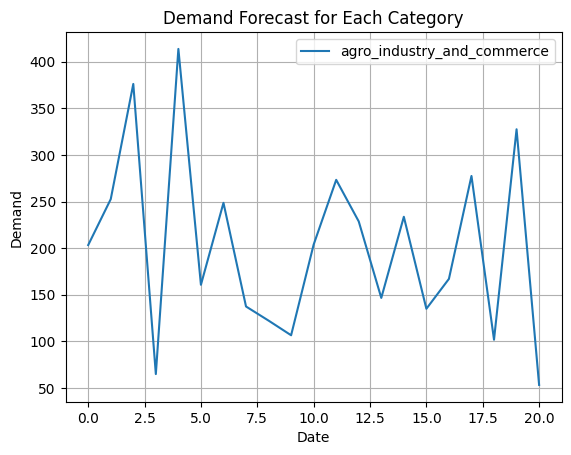

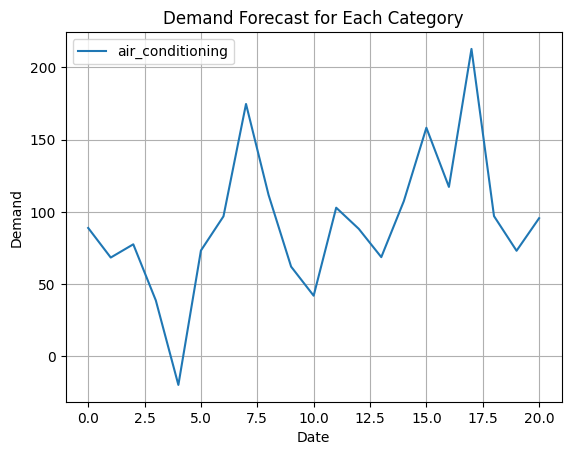

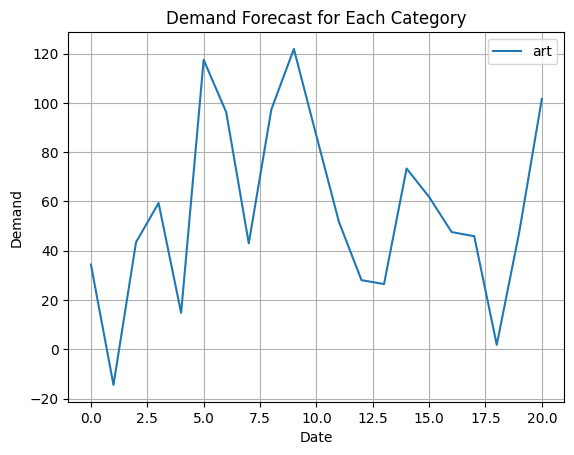

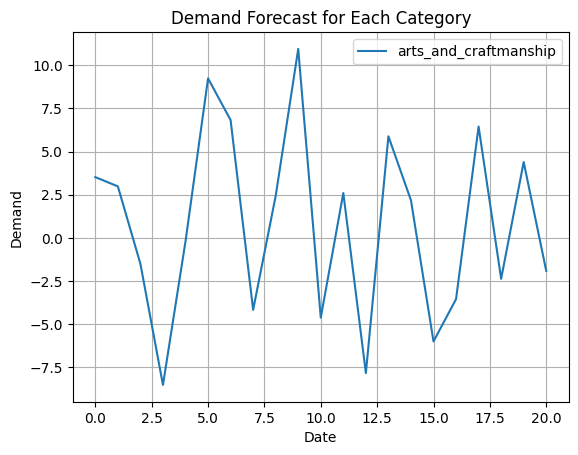

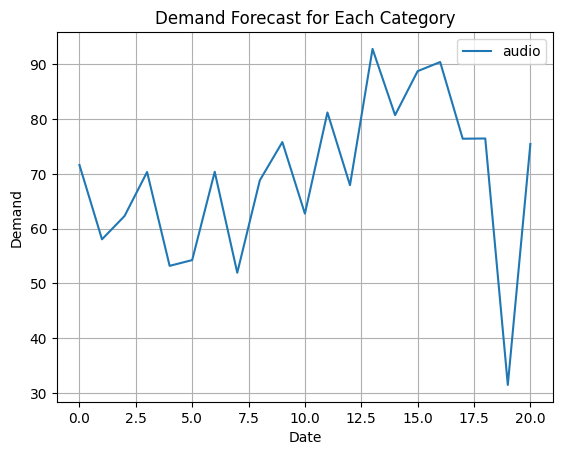

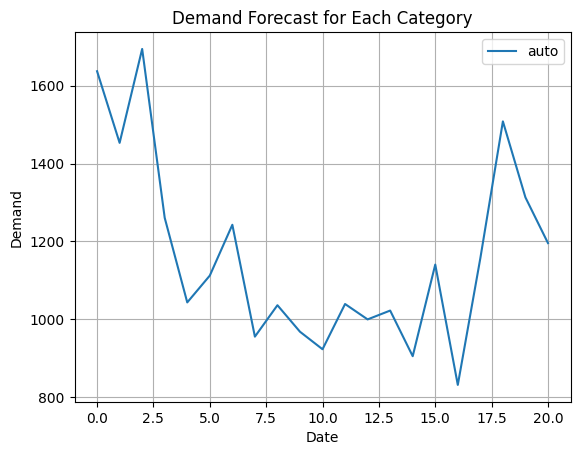

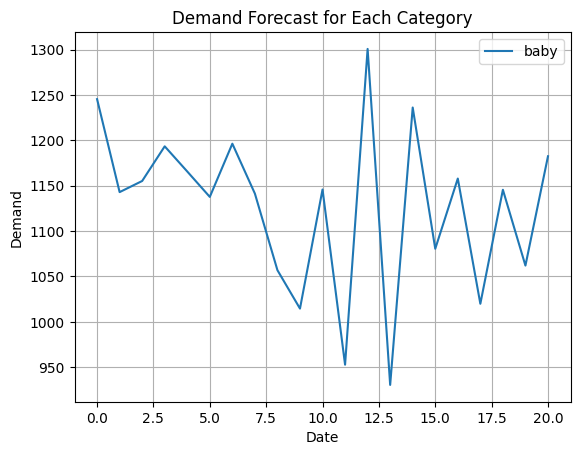

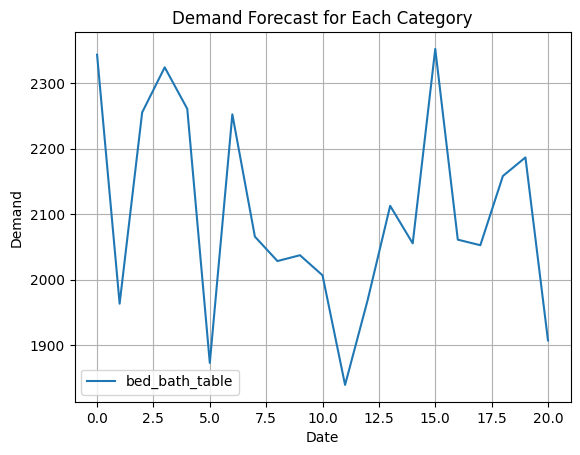

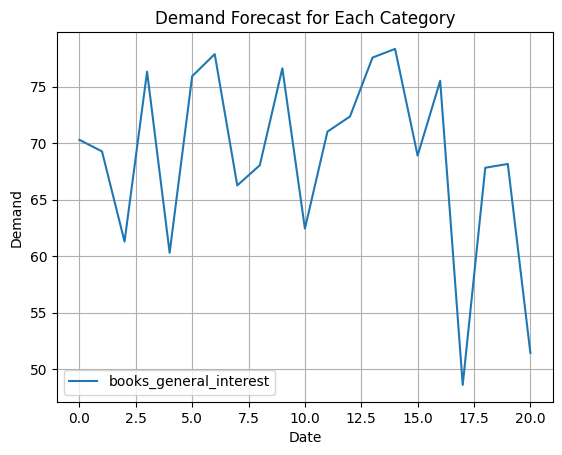

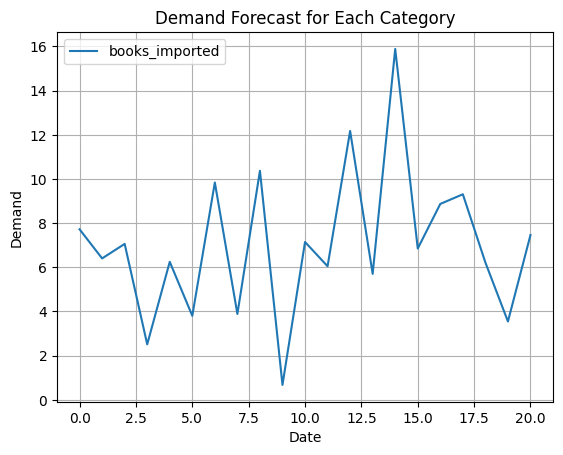

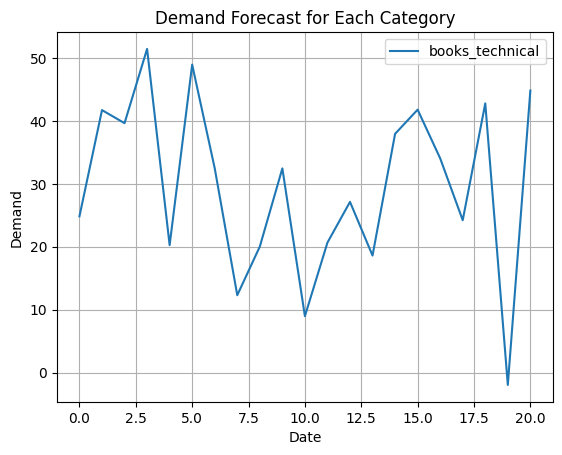

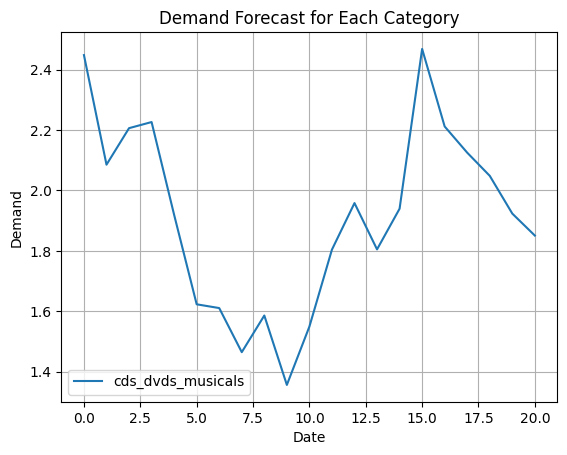

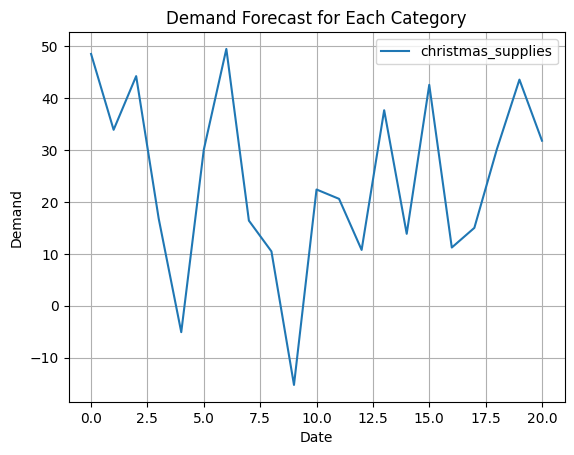

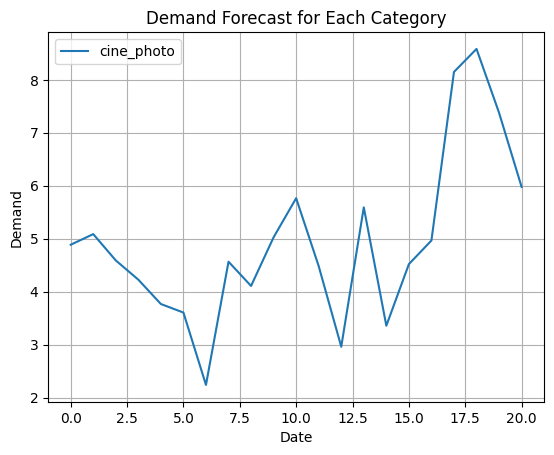

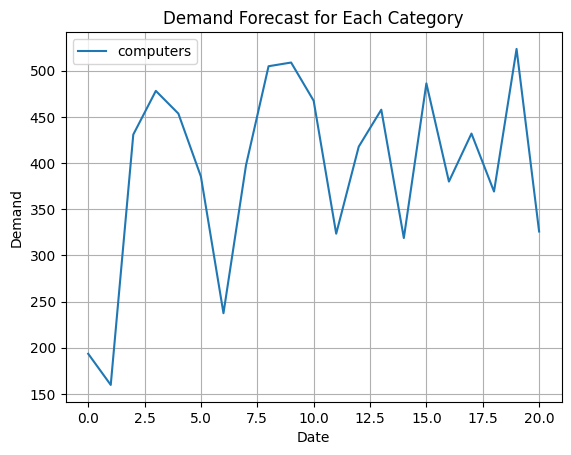

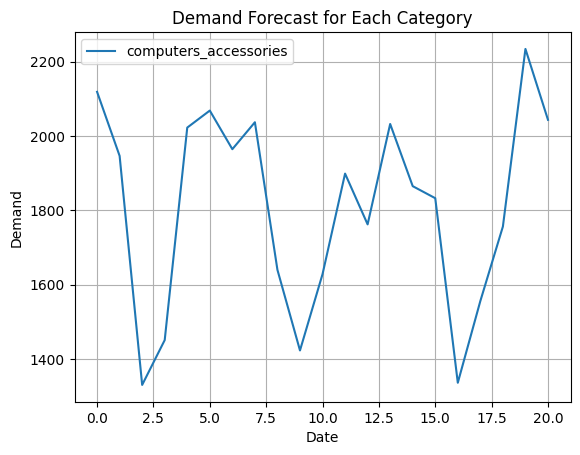

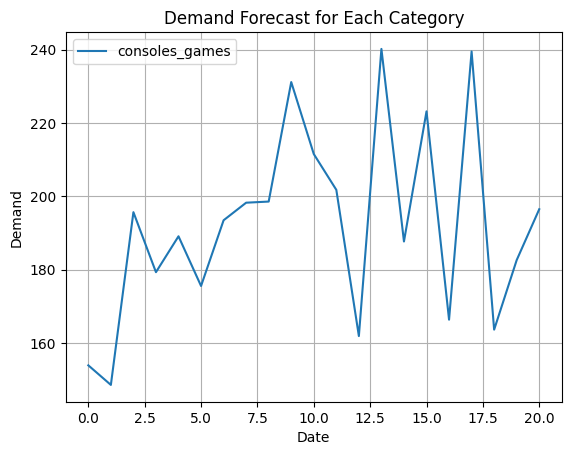

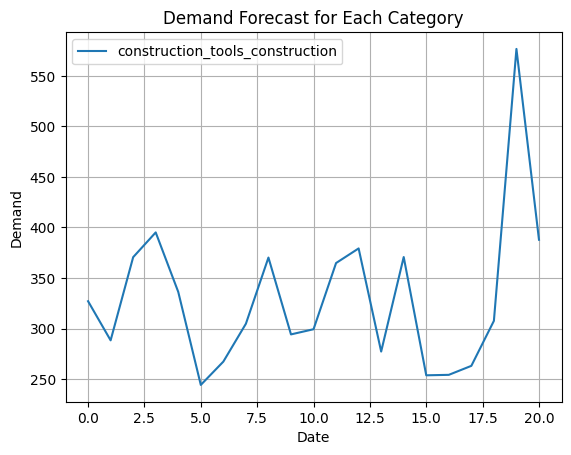

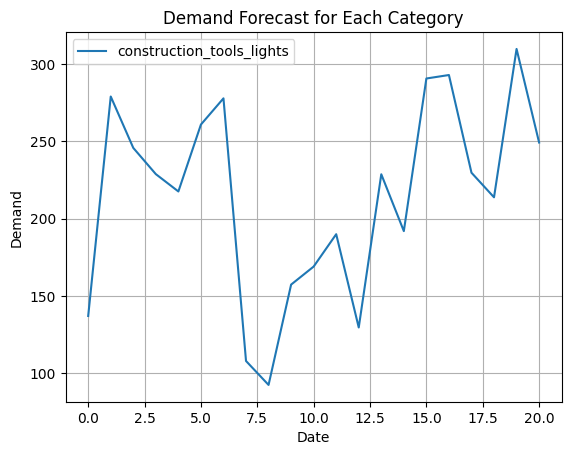

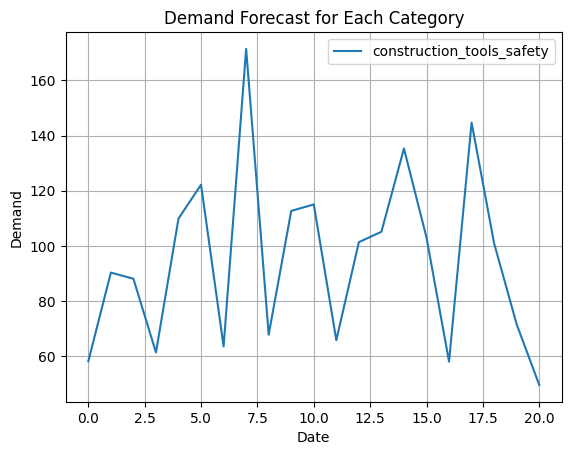

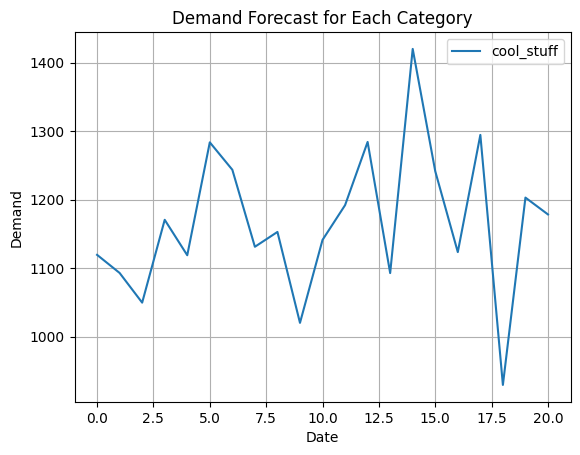

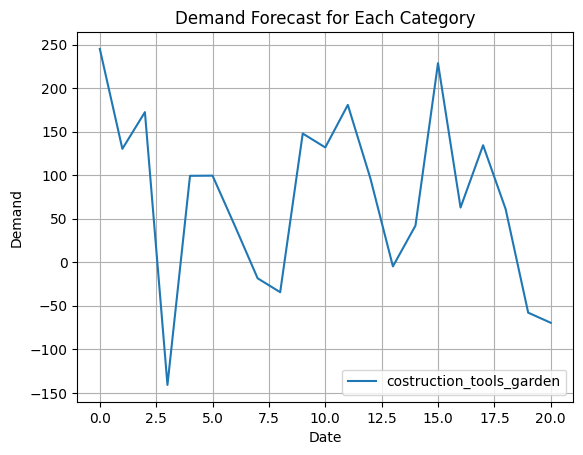

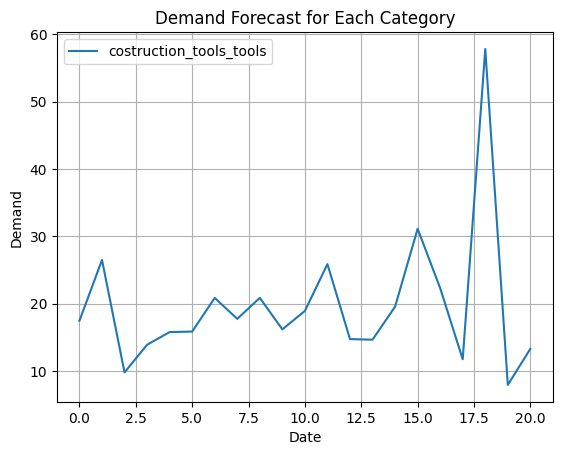

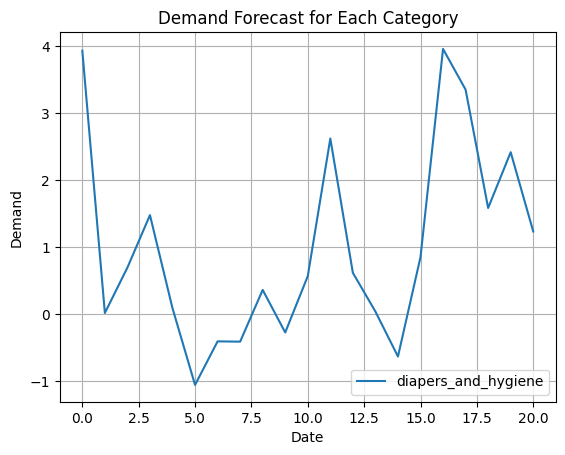

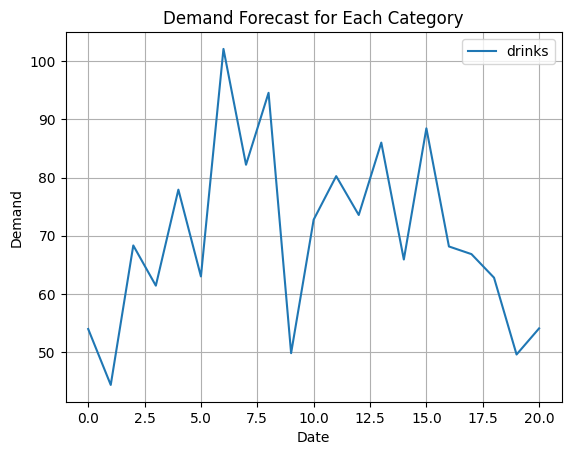

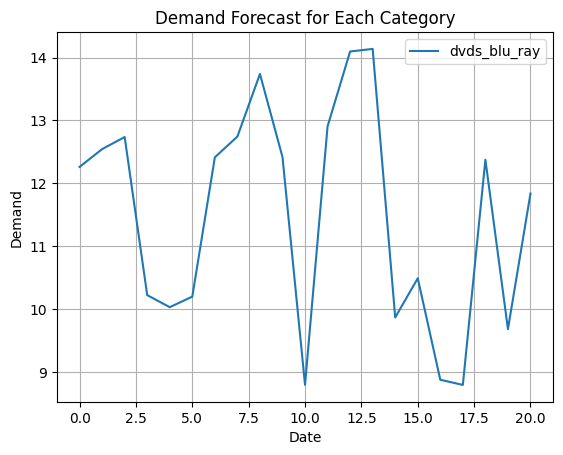

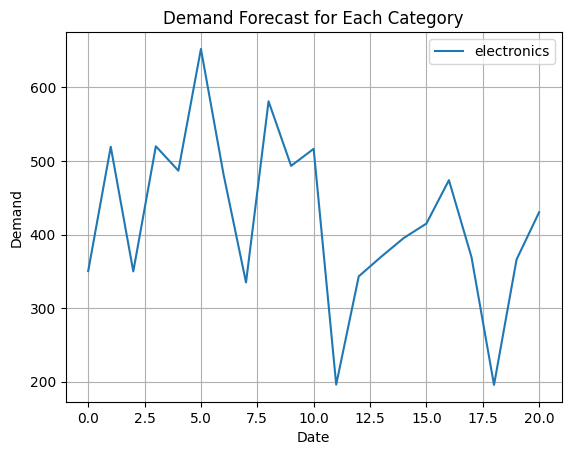

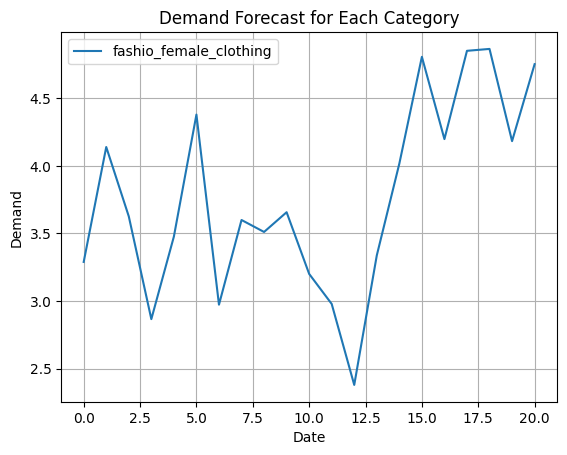

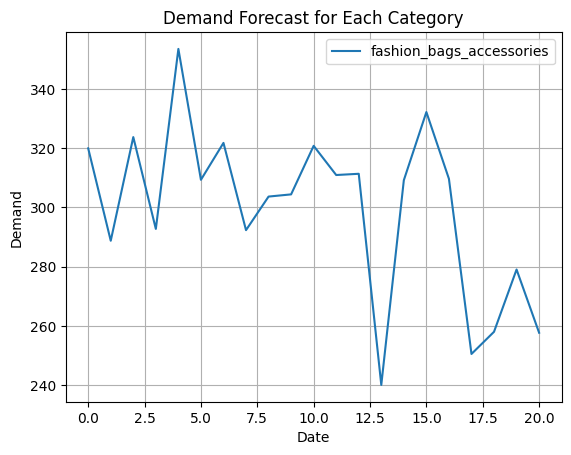

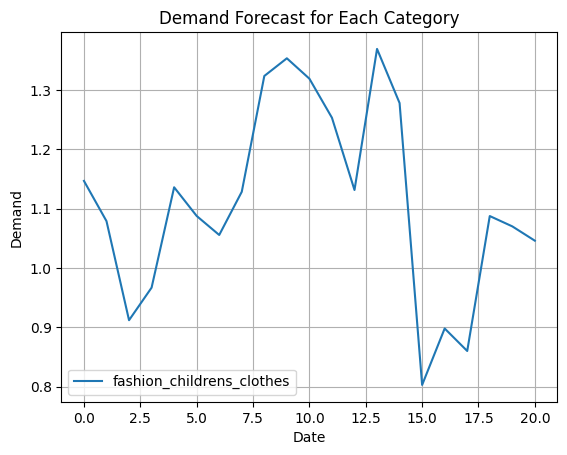

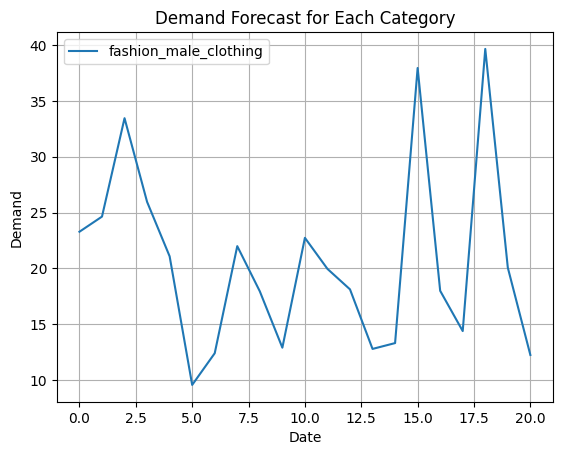

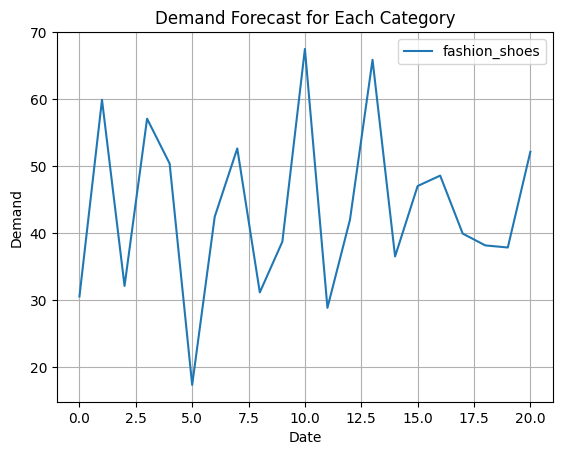

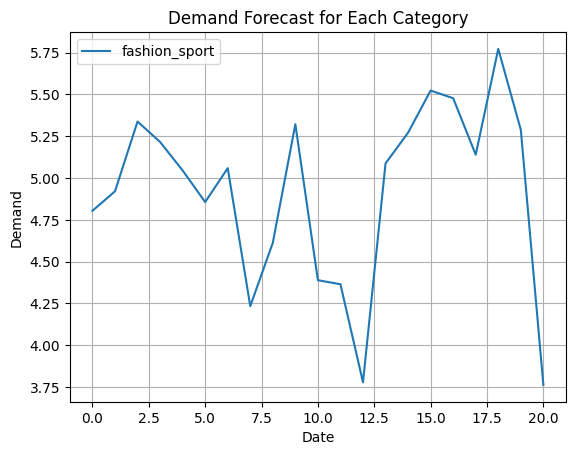

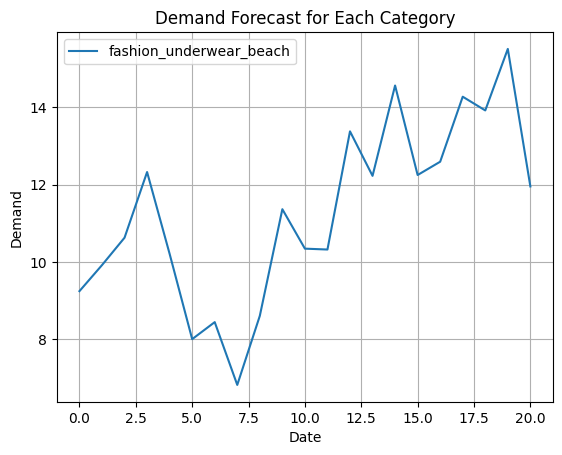

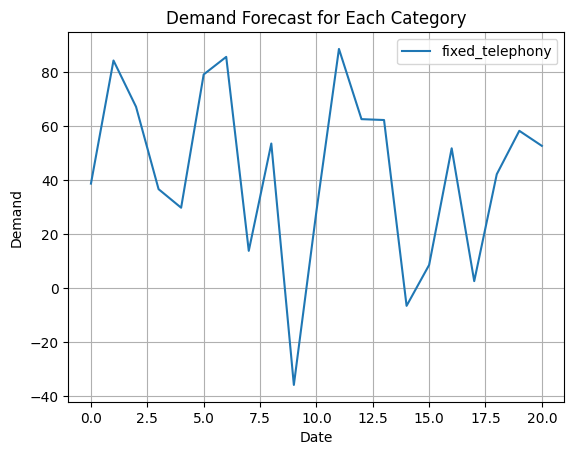

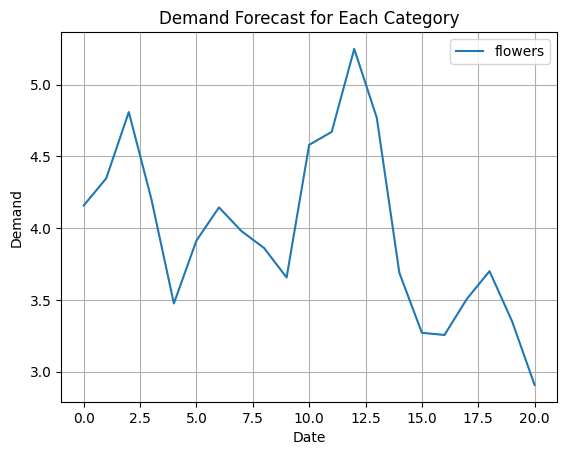

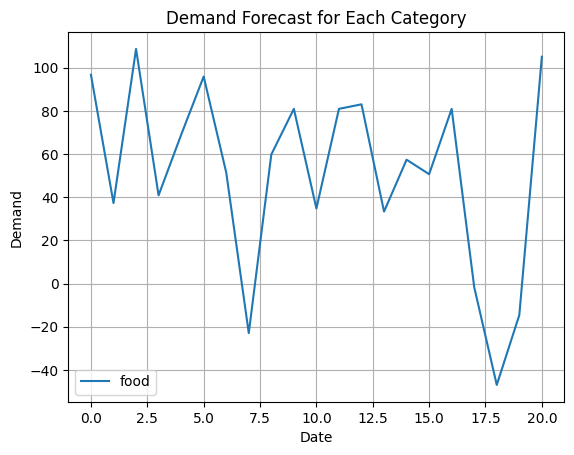

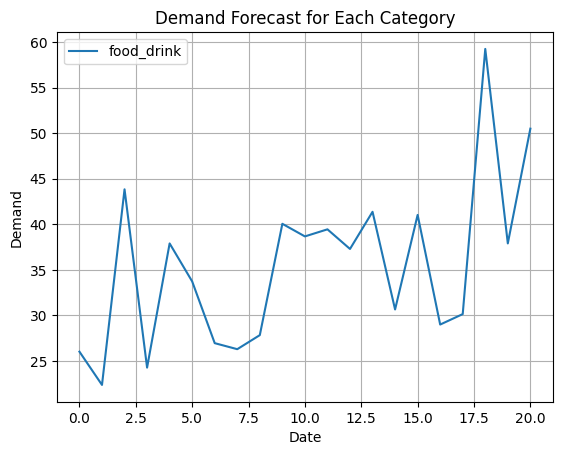

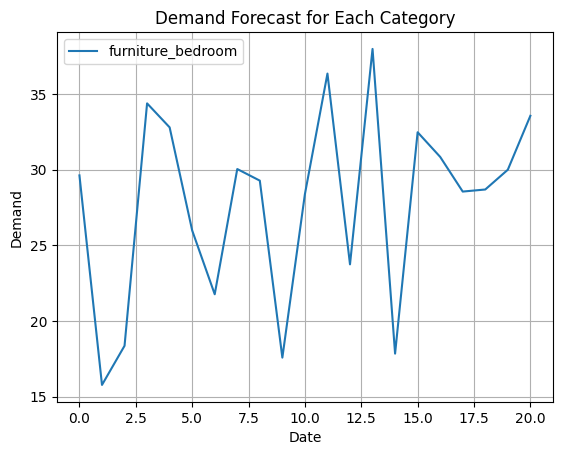

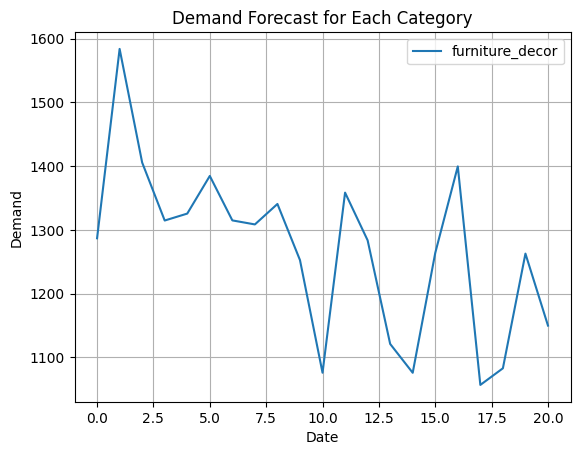

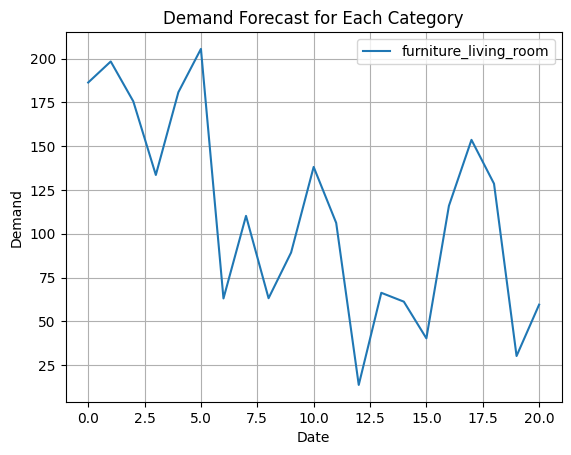

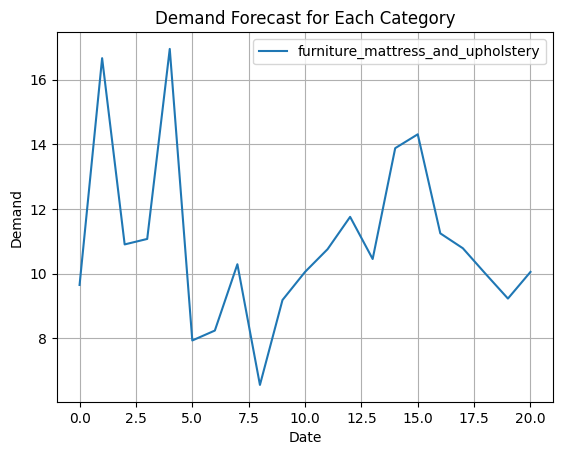

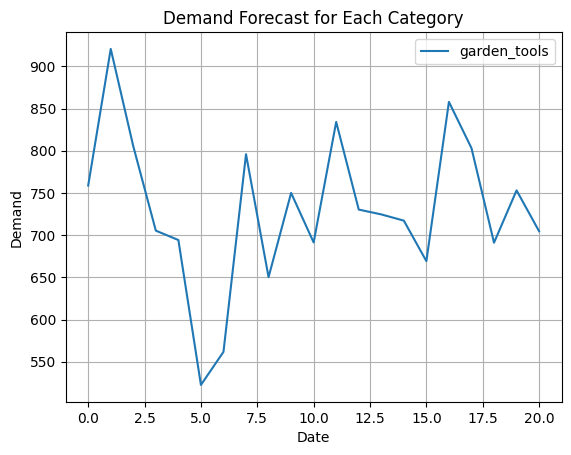

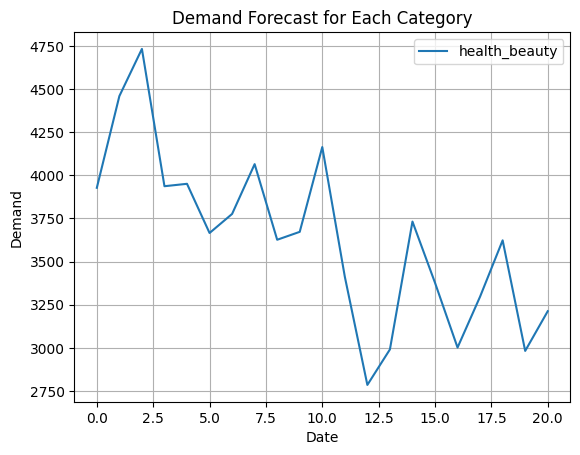

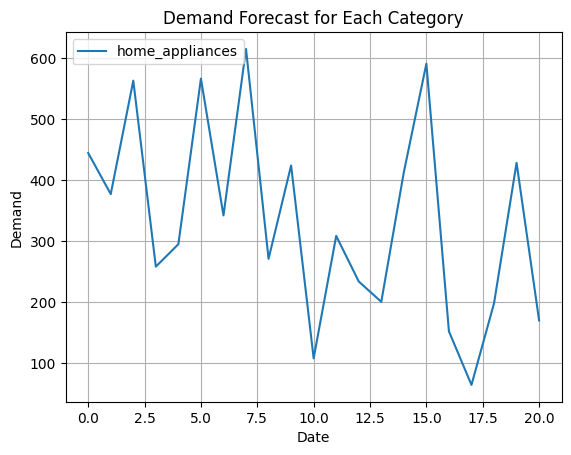

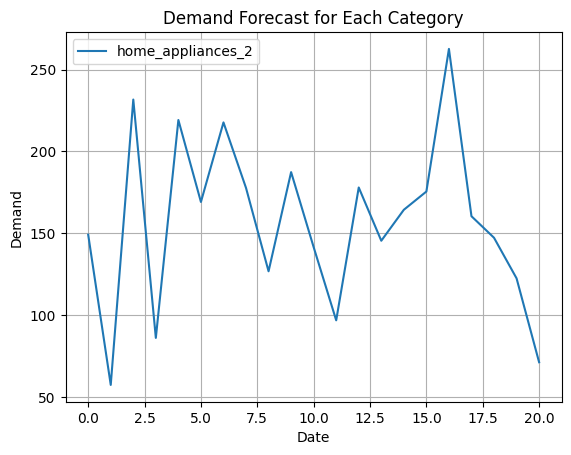

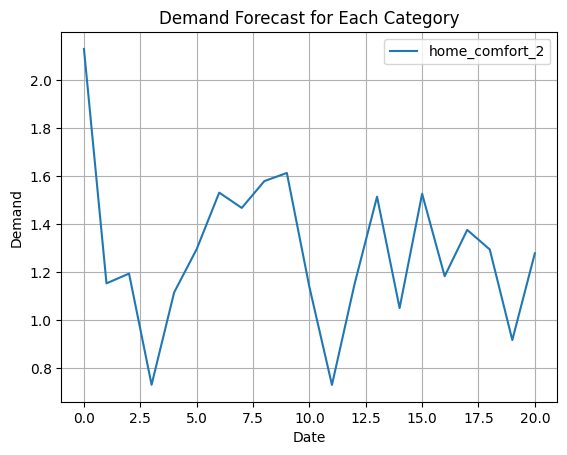

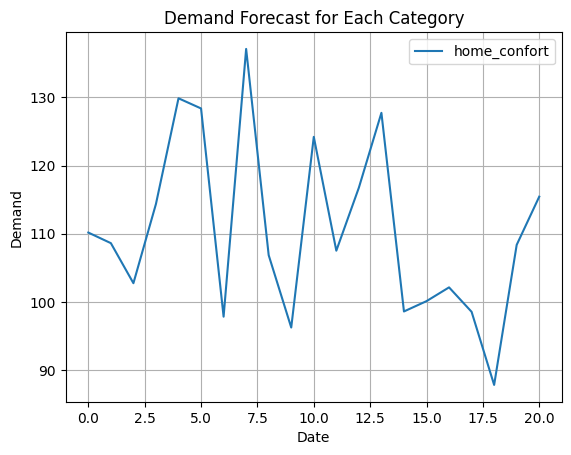

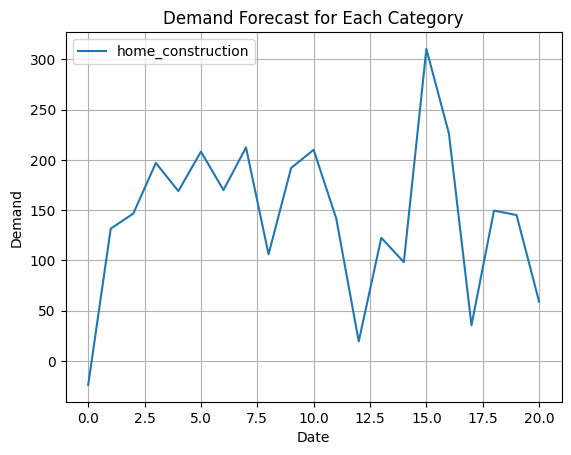

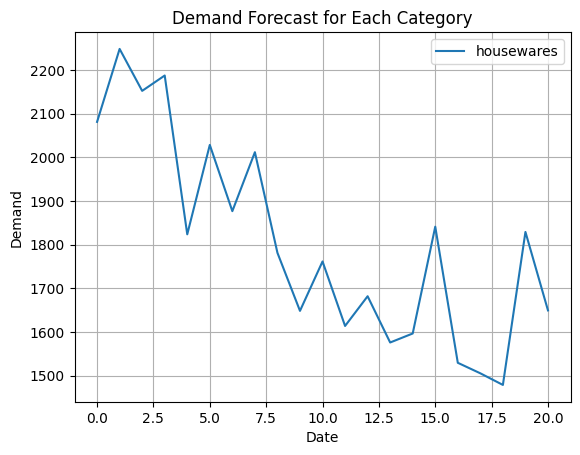

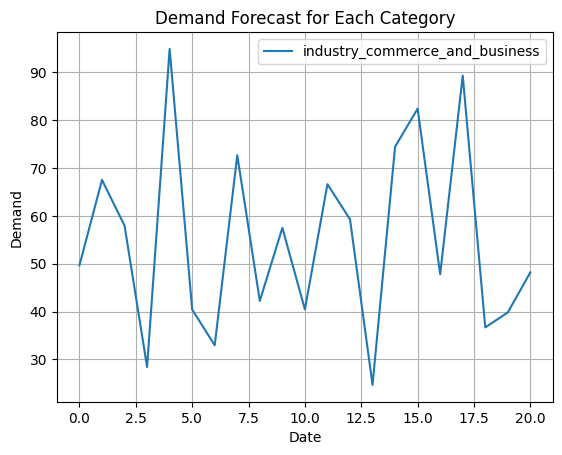

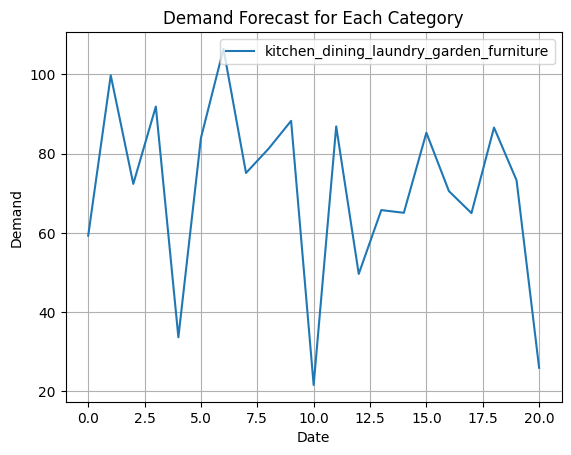

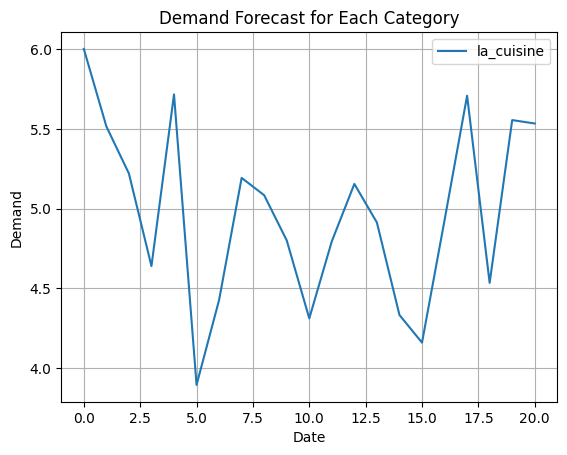

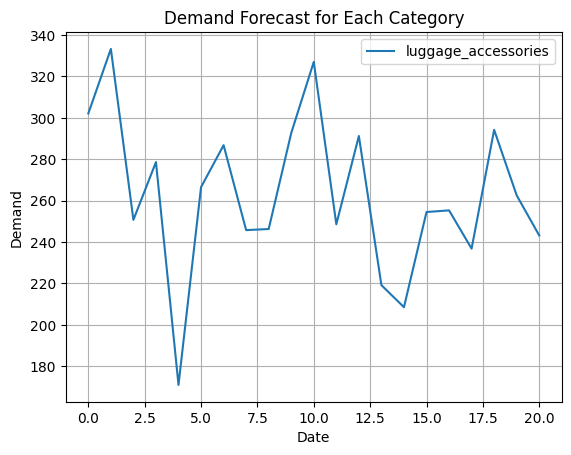

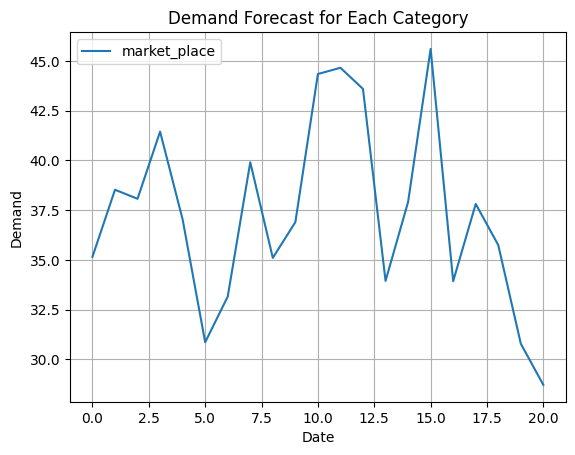

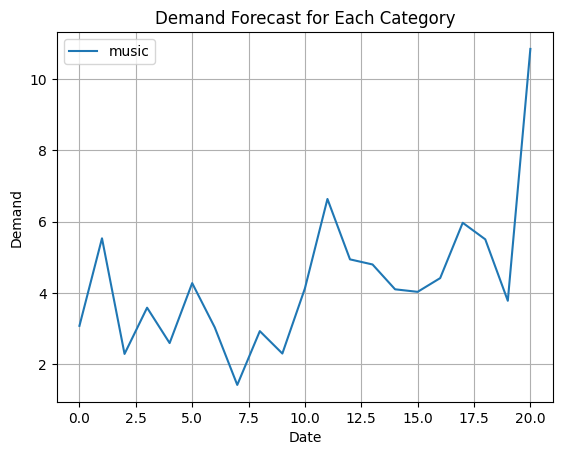

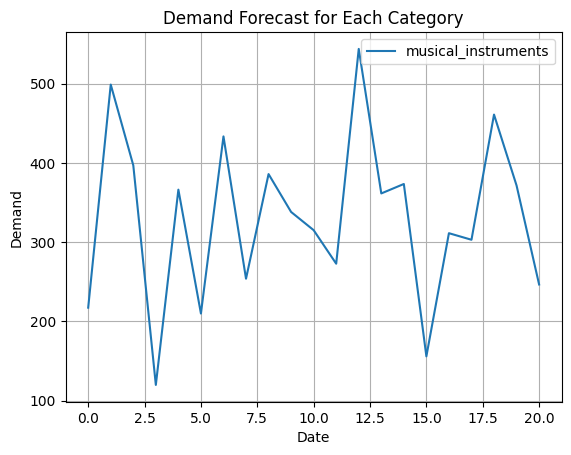

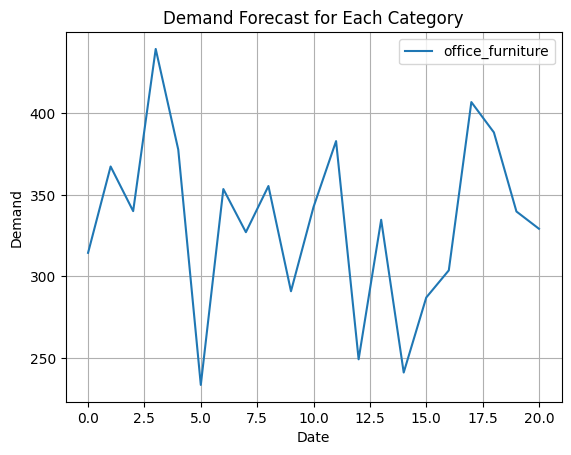

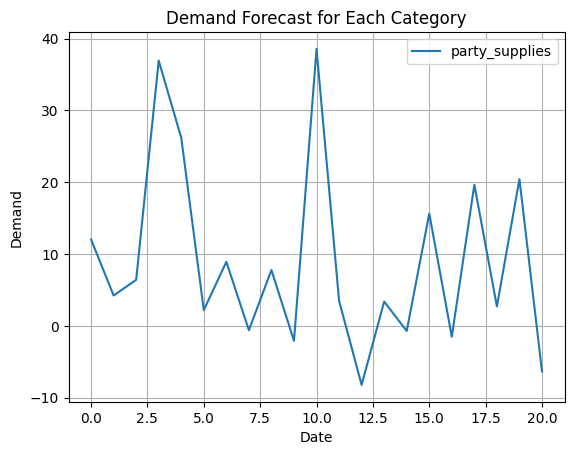

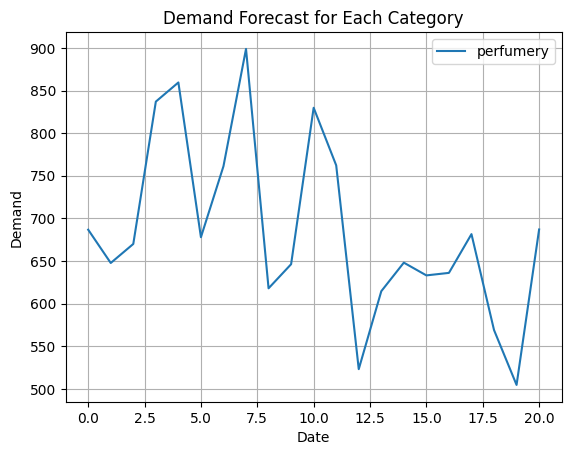

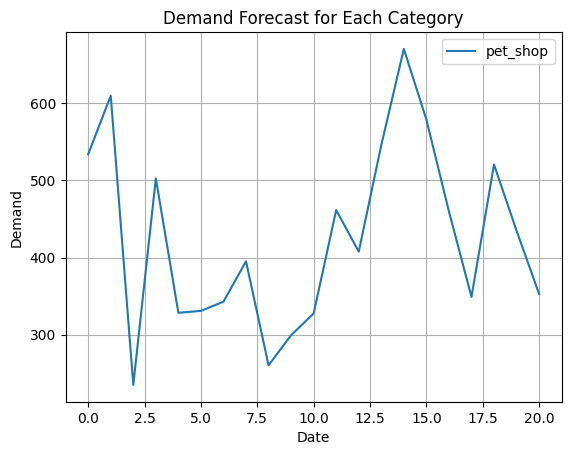

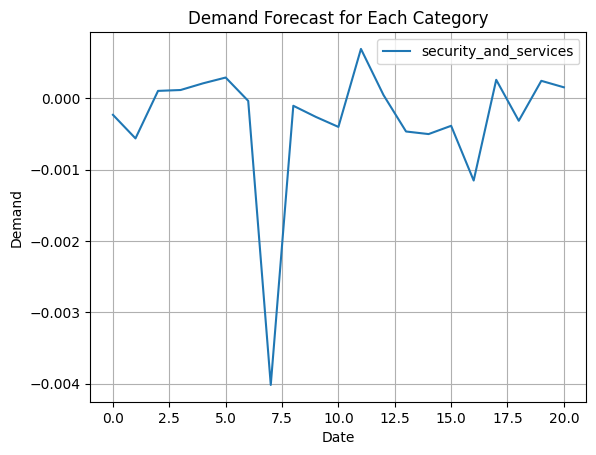

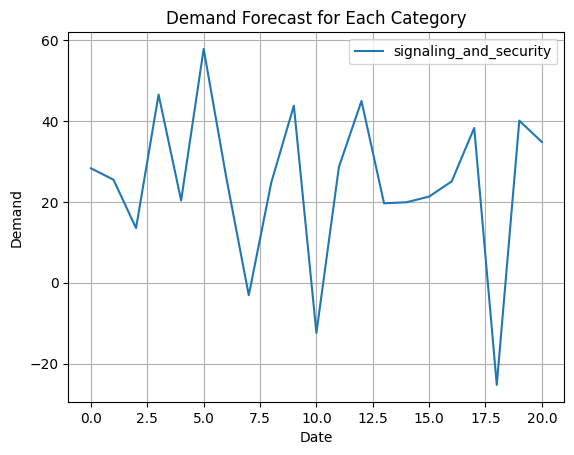

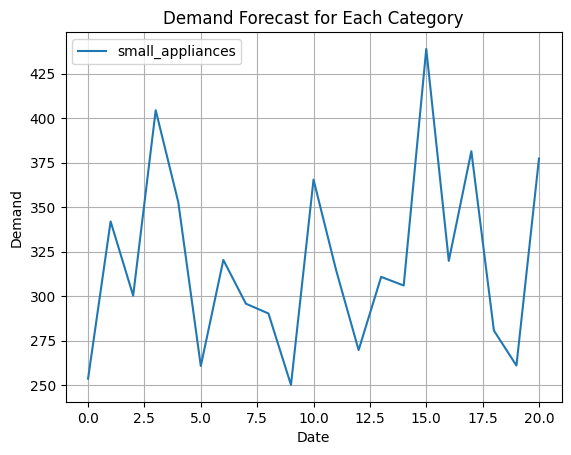

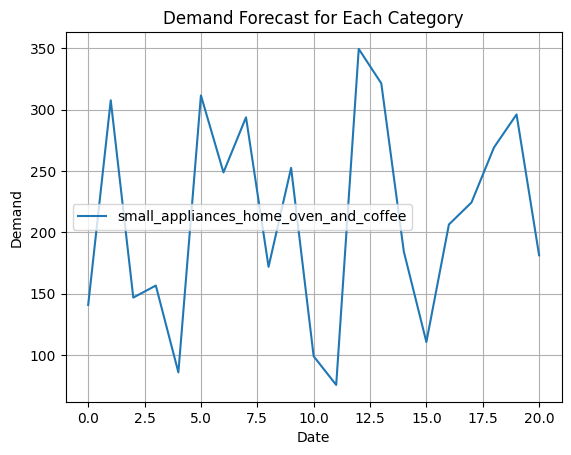

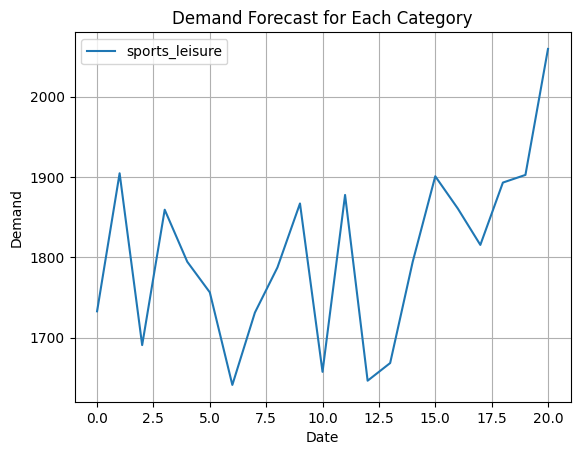

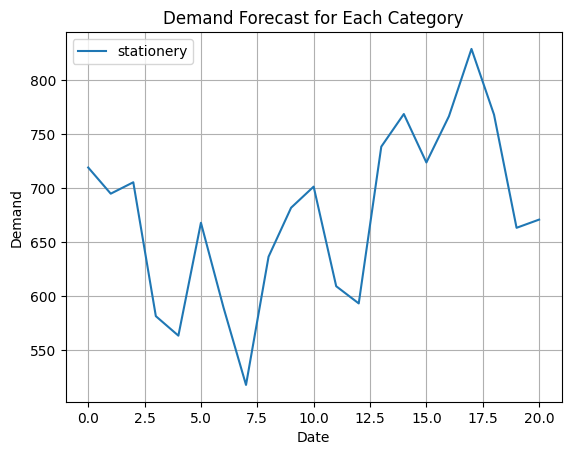

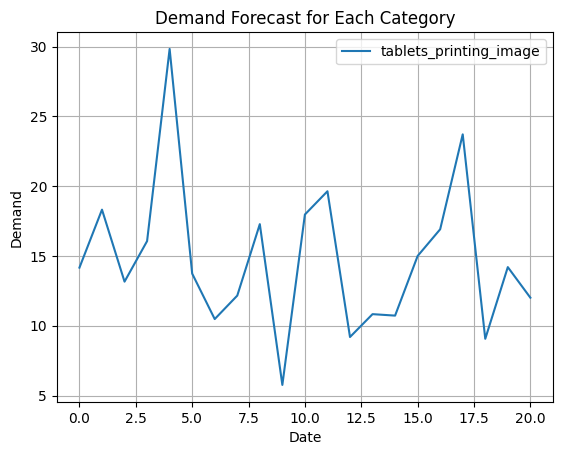

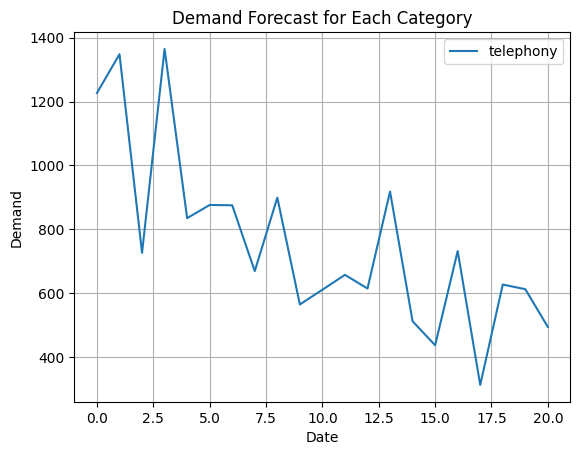

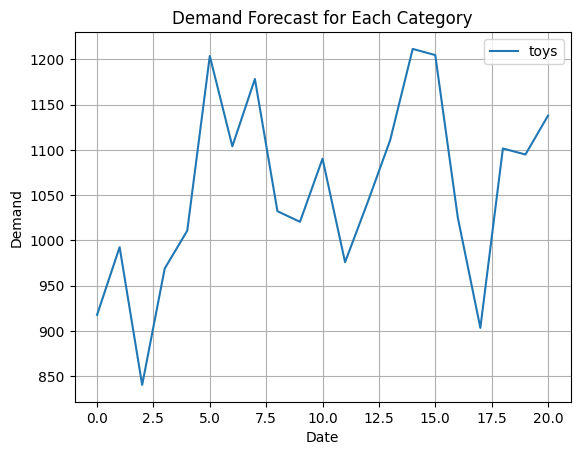

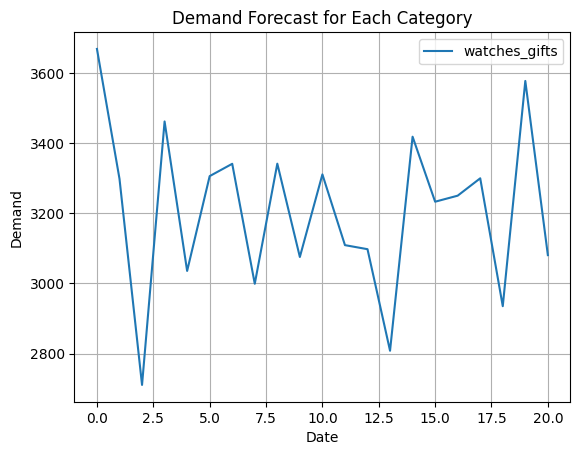

In [5]:
import matplotlib.pyplot as plt

# Plot demand forecasts for each category
# plt.figure(figsize=(12, 8))

for category in demand_forecast_nn.keys():
    plt.plot(range(21), demand_forecast_nn[category], label=category)

    plt.title('Demand Forecast for Each Category')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.grid(True)
    plt.show()

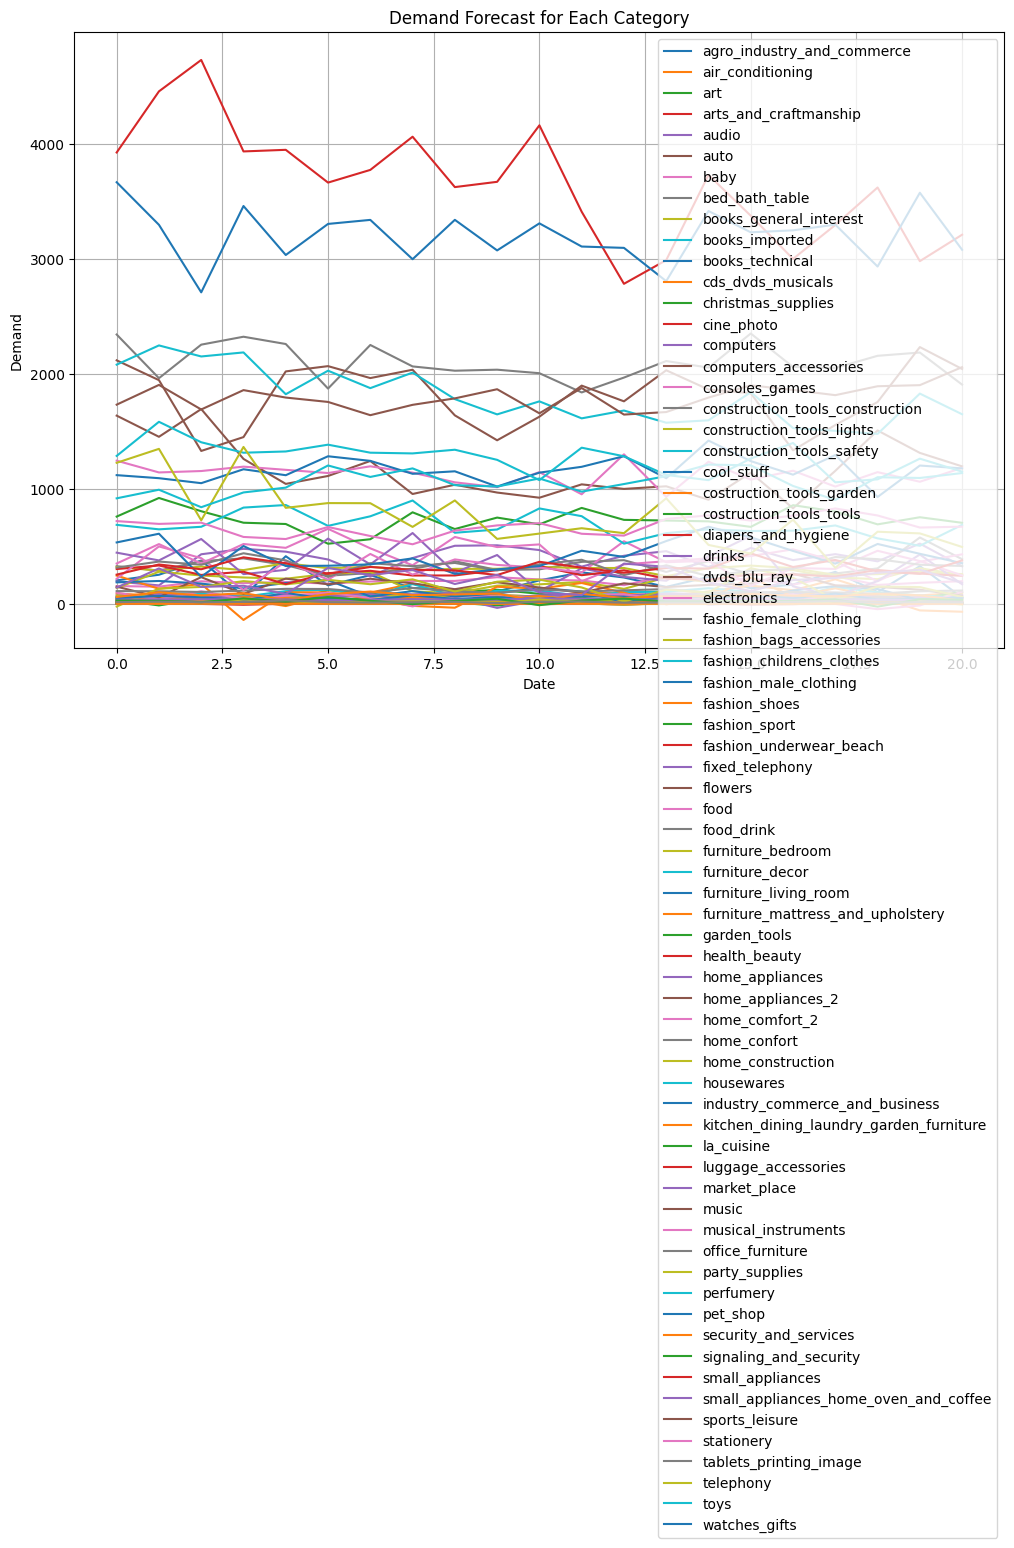

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for category in demand_forecast_nn.keys():
    plt.plot(range(21), demand_forecast_nn[category], label=category)

plt.title('Demand Forecast for Each Category')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)
plt.show()